In [1]:
import sys
import mne
import scipy.io as sp
from scipy import interpolate
import numpy as np
import random
import pandas as pd
import multiprocessing as mp
import concurrent.futures
from mne.decoding import CSP
import pymrmr
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC as SVM
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging
from scipy.io import loadmat
from scipy.signal import cheby2, filtfilt
from scipy.signal import hamming
from scipy.signal import hann
from scipy.signal import blackman
from scipy.signal import kaiser
from scipy.signal import gaussian
from sklearn.decomposition import FastICA
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
# import lightgbm as lgb
# from catboost import CatBoostClassifier
# from sklearn.impute import KNNImputer
# from sklearn.decomposition import PCA
# from pyriemann.estimation import Covariances
# from pyriemann.tangentspace import TangentSpace
# from pyriemann.classification import MDM
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import os
import pickle
import multiprocessing
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Circle
from matplotlib.font_manager import FontProperties
from mne.decoding import SPoC



/home/mahdi146/jupyter2/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Set display options for NumPy
np.set_printoptions(threshold=np.inf)

# Initialization

In [4]:
WINDOW_TIME_LENGTH = 4
SAMPLING_RATE = 250
NUMBER_OF_CHANNELS = 64
beta = 1.5

epoch_length = 1000
sampling_freq = 250
number_of_runs = 10
number_of_components = 10
number_of_selected_features = 10
number_of_processes = 10
number_of_bands = 9
column_names = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block']
column_names_v2 = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block','test_acc_vote']


trial_order=[['Tongue','Feet','Mis','Hand'],
            ['Feet','Mis','Hand','Tongue'],
            ['Hand','Feet','Tongue','Mis'],
            ['Tongue','Mis','Hand','Feet'],
            ['Mis','Feet','Hand','Tongue'],
            ['Feet','Hand','Tongue','Mis'],
            ['Hand','Tongue','Mis','Feet'],
            ['Tongue','Feet','Mis','Hand'],
            ['Mis','Tongue','Hand','Feet']]


# Functions

In [5]:
def get_task_rest_times(b_num):
    if b_num == 0:
        task_time = [[12, 16, 20, 8],
                    [16, 12, 20, 8],
                    [20, 16, 8, 12],
                    [20, 12, 8, 16]]
        
        rest_time = [[20, 8, 16, 12],
                    [16, 20, 8, 12],
                    [12, 20, 16, 8],
                    [20, 12, 8, 16]]
        
    elif b_num == 1:
        task_time = [[12, 8, 20, 16],
                    [16, 20, 8, 12],
                    [8, 20, 16, 12],
                    [8, 12, 20, 16]]
        
        rest_time = [[16, 12, 8, 20],
                    [8, 20, 12, 16],
                    [20, 16, 8, 12],
                    [12, 16, 20, 8]]
        
    elif b_num == 2:
        task_time = [[16, 8, 12, 20],
                    [20, 16, 12, 8],
                    [12, 20, 8, 16],
                    [8, 12, 16, 20]]
        
        rest_time = [[8, 20, 16, 12],
                    [12, 8, 20, 16],
                    [16, 12, 20, 8],
                    [8, 12, 20, 16]]
        
    elif b_num == 3:
        task_time = [[12, 16, 20, 8],
                    [16, 12, 20, 8],
                    [20, 16, 8, 12],
                    [20, 12, 8, 16]]
        
        rest_time = [[20, 8, 16, 12],
                    [16, 20, 8, 12],
                    [12, 20, 16, 8],
                    [20, 12, 8, 16]]
        
    elif b_num == 4:
        task_time = [[16, 8, 20, 12],
                    [12, 16, 8, 20],
                    [20, 8, 12, 16],
                    [8, 20, 12, 16]]
        
        rest_time = [[8, 12, 16, 20],
                    [16, 20, 12, 8],
                    [12, 16, 8, 20],
                    [20, 8, 12, 16]]
        
    elif b_num == 5:
        task_time = [[16, 12, 8, 20],
                    [20, 16, 12, 8],
                    [8, 16, 20, 12],
                    [12, 8, 16, 20]]

        rest_time = [[12, 8, 16, 20],
                    [16, 8, 20, 12],
                    [20, 12, 16, 8],
                    [8, 16, 12, 20]]
        
    elif b_num == 6:
        task_time = [[16, 8, 12, 20],
                    [20, 8, 16, 12],
                    [8, 16, 12, 20],
                    [16, 20, 12, 8]]

        rest_time = [[16, 8, 12, 20],
                    [12, 20, 8, 16],
                    [20, 16, 12, 8],
                    [8, 16, 20, 12]]     
    elif b_num ==7:
        task_time = [[12, 8, 20, 16],
                    [16, 20, 8, 12],
                    [8, 20, 16, 12],
                    [8, 12, 20, 16]]   
               
        rest_time = [[16, 12, 8, 20],
                    [8, 20, 12, 16],
                    [20, 16, 8, 12],
                    [12, 16, 20, 8]]  
    
    elif b_num == 8:
        task_time = [[16, 8, 12, 20],
                    [20, 16, 12, 8],
                    [12, 20, 8, 16],
                    [8, 12, 16, 20]]
        
        rest_time = [[8, 20, 16, 12],
                    [12, 8, 20, 16],
                    [16, 12, 20, 8],
                    [8, 12, 20, 16]]
        
    else:
        raise("Error in block number")
    

    return task_time,rest_time


In [6]:
def trial_times_genertor(task_times,rest_times):
    block_times = [item for pair in zip(task_times, rest_times) for item in pair]
    return block_times
    

In [7]:

def fill_zeros_with_average(matrix):
    # Iterate through the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for k in range(matrix.shape[2]):
                if matrix[i, j, k] == 0:
                    # Find the neighboring non-zero elements
                    neighbors = []
                    if i > 0 and matrix[i - 1, j, k] != 0:
                        neighbors.append(matrix[i - 1, j, k])
                    if i < matrix.shape[0] - 1 and matrix[i + 1, j, k] != 0:
                        neighbors.append(matrix[i + 1, j, k])
                    if j > 0 and matrix[i, j - 1, k] != 0:
                        neighbors.append(matrix[i, j - 1, k])
                    if j < matrix.shape[1] - 1 and matrix[i, j + 1, k] != 0:
                        neighbors.append(matrix[i, j + 1, k])
                    if k > 0 and matrix[i, j, k - 1] != 0:
                        neighbors.append(matrix[i, j, k - 1])
                    if k < matrix.shape[2] - 1 and matrix[i, j, k + 1] != 0:
                        neighbors.append(matrix[i, j, k + 1])

                    # Fill the zero with the average of neighboring non-zero values
                    if neighbors:
                        matrix[i, j, k] = sum(neighbors) / len(neighbors)

    return matrix

In [8]:
def calc_csp(x_train, y_train, x_test,number_of_components):
    # csp = CSP(n_components=number_of_components, reg='ledoit_wolf', log=True)
    csp = CSP(number_of_components)



    
    # x_train = fill_zeros_with_average(x_train)
    # x_train = np.add(x_train, 0.000001)



    # nan_count = np.isnan(x_train).sum()
    # print("Number of NaN values:", nan_count)

    # empty_field_count = np.count_nonzero(x_train == 0)
    # print("Number of empty fields:", empty_field_count)

    # zeros_locations_3d = np.where(x_train == 0)
    # print("Locations of zeros:", zeros_locations)
    
# Printing indices and corresponding values
    # for depth_idx, row_idx, col_idx in zip(zeros_locations_3d[0], zeros_locations_3d[1], zeros_locations_3d[2]):
    #     value_at_zero_location = x_train[depth_idx, row_idx, col_idx]
    #     print(f"Zero found at position ({depth_idx}, {row_idx}, {col_idx}) with value {value_at_zero_location}")


    csp_fit = csp.fit(x_train, y_train)
    # print(csp.patterns_,"csp.patterns_")
    # sys.exit()
    train_feat = csp_fit.transform(x_train)
    test_feat = csp_fit.transform(x_test)
    return train_feat, test_feat

In [9]:
def calc_csp_v2(x_train, y_train, x_test,y_test,number_of_components):
    # csp = CSP(n_components=number_of_components, reg='ledoit_wolf', log=True)
    # csp = CSP(number_of_components)
    spoc = SPoC(n_components=2, log=True, reg="oas", rank="full")
    # spoc = SPoC(n_components=10)
    spoc_fit = spoc.fit(x_train,y_train)
    train_feat = spoc_fit.transform(x_train)
    test_feat = spoc_fit.transform(x_test)




    
    # x_train = fill_zeros_with_average(x_train)
    # x_train = np.add(x_train, 0.000001)



    # nan_count = np.isnan(x_train).sum()
    # print("Number of NaN values:", nan_count)

    # empty_field_count = np.count_nonzero(x_train == 0)
    # print("Number of empty fields:", empty_field_count)

    # zeros_locations_3d = np.where(x_train == 0)
    # print("Locations of zeros:", zeros_locations)
    
# Printing indices and corresponding values
    # for depth_idx, row_idx, col_idx in zip(zeros_locations_3d[0], zeros_locations_3d[1], zeros_locations_3d[2]):
    #     value_at_zero_location = x_train[depth_idx, row_idx, col_idx]
    #     print(f"Zero found at position ({depth_idx}, {row_idx}, {col_idx}) with value {value_at_zero_location}")
    
    # y_test = np.squeeze(y_test)
    # print(y_test.shape,y_train.shape,"y_test y_train shape")

    # csp_fit_tr = csp.fit(x_train, y_train)
    # csp_fit_te = csp.fit(x_test, y_test)
    
    # print(csp.patterns_,"csp.patterns_")
    # sys.exit()
    # train_feat = csp.fit_transform(x_train,y_train)
    # test_feat = csp.fit_transform(x_test,y_test)
    
    return train_feat, test_feat

In [10]:
def class_extractor(number_of_epochs, class_1, class_2, data, labels):
    size = sum(labels[:,0] == class_1) + sum(labels[:,0] == class_2)
    Final_labels = np.zeros((size,1)).astype(int)
    dataset = np.zeros((size,num_channels, epoch_length))
    index = 0
    for i in range(number_of_epochs):
        if labels[i,0] == class_1 or labels[i,0] == class_2:
            dataset[index,:,:] = data[i,:,:]
            Final_labels[index,0] = labels[i,0]
            index = index + 1
        else:
            continue
            
    return dataset, Final_labels

In [62]:
def feature_extractor(dataset, labels, number_of_bands, test_data,number_of_components):

    low_cutoff = 0
    

    for b in range(number_of_bands):
        logging.getLogger('mne').setLevel(logging.WARNING)
        low_cutoff += 4
        data = dataset.copy()

        fmin, fmax = 1, 250  # Define frequency range of interest
        psds, freqs = mne.time_frequency.psd_array_multitaper(x=data, sfreq=250,fmin=fmin, fmax=fmax)
        print(freqs[-1])
        print(psds.shape,freqs.shape,"shape psd")
        # Plot power spectral density
        plt.plot(freqs, psds[0,0,:].T, color='k', alpha=0.5)
       
        sys.exit()
        data_test = test_data.copy() 
        print("Frequency range: ",low_cutoff)
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        filtered_data_test = mne.filter.filter_data(test_data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)

        #PCA
        # from mne.decoding import UnsupervisedSpatialFilter
        # from sklearn.decomposition import PCA, FastICA

        # pca = UnsupervisedSpatialFilter(PCA(64), average=False)
        # pca_fit = pca.fit(filtered_data)
        # filtered_data = pca_fit.transform(filtered_data)
        # filtered_data_test = pca_fit.transform(filtered_data_test)
        # train_feats = filtered_data
        # test_feats = filtered_data_test

        # filtered_data = data
        # filtered_data_test = data_test
        
        [train_feats, test_feats] = calc_csp(filtered_data, labels[:,0], filtered_data_test,number_of_components)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
    
    return train_features, test_features

In [12]:
def feature_extractor_v2(dataset, labels, number_of_bands, test_data,labels_test,number_of_components):

    low_cutoff = 0
    number_of_bands = 20
    slide = 0.5
    
    for b in range(number_of_bands):
        logging.getLogger('mne').setLevel(logging.WARNING)
        low_cutoff += slide
        data = dataset.copy()
        data_test = test_data.copy() 
        print("Frequency range: ",low_cutoff)
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + slide, verbose = False, n_jobs = 4)
        filtered_data_test = mne.filter.filter_data(test_data, sampling_freq, low_cutoff, low_cutoff + slide, verbose = False, n_jobs = 4)

        #PCA
        # from mne.decoding import UnsupervisedSpatialFilter
        # from sklearn.decomposition import PCA, FastICA

        # pca = UnsupervisedSpatialFilter(PCA(64), average=False)
        # pca_fit = pca.fit(filtered_data)
        # filtered_data = pca_fit.transform(filtered_data)
        # filtered_data_test = pca_fit.transform(filtered_data_test)
        # train_feats = filtered_data
        # test_feats = filtered_data_test

        # filtered_data = data
        # filtered_data_test = data_test
        
        [train_feats, test_feats] = calc_csp_v2(filtered_data, labels[:,0], filtered_data_test,labels_test,number_of_components)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
    
    return train_features, test_features

In [13]:
def feature_selector(train_features, labels, number_of_selected_features):
    X = pd.DataFrame(train_features)
    y = pd.DataFrame(labels)
    K = number_of_selected_features
    
    df = pd.concat([y,X], axis = 1)
    df.columns = df.columns.astype(str)
        
    selected_features = list(map(int, pymrmr.mRMR(df, 'MID', K)))
    return selected_features

In [14]:
def feature_selector_ref(train_features, labels, classifier, number_of_selected_features):
    X = train_features
    y = labels
    classifier.fit(X, y)
    rfe = RFE(estimator=classifier, n_features_to_select=number_of_selected_features)
    rfe.fit(X, y)
    selected_features = np.array(X.columns)[rfe.support_]

    return selected_features

In [15]:
def data_reader(path,p_num,block_list):
    data_dict = {}
    for b_num in block_list:
        print(b_num)
        mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
        df = pd.DataFrame(mat['Data'])
        data_dict[b_num] = df
    return data_dict


In [16]:
def get_group_start_indices(dataframe):
    group_indices = []
    current_label = None

    for idx, row in dataframe.iterrows():
        if row.iloc[-1] != current_label:
            group_indices.append(idx)
            current_label = row.iloc[-1]

    return group_indices

In [17]:
def extra_samples_counter(df,class_1,class_2):
    x=0
    i=0
    sampleList = []
    while i<len(df):
        if (df.iloc[i,-1]==class_1):
            x+=1
        else:
            i-=1
            sampleList.append(x)
            x=0
            class_1,class_2 = class_2,class_1
        i+=1
    sampleList.append(x)
    print(sampleList)
    

In [18]:
def extra_samples_block_counter(df,trial_order,b_num):

    df.drop(df[df.iloc[:,-1].isin(['Begin', 'End'])].index, inplace=True)
    df.reset_index(drop=True, inplace=True)    
    df['group'] = (df.iloc[:,-1] != df.iloc[:,-1].shift(1)).cumsum()

    
    group_counts_Rest = df[df.iloc[:,-1] == 'Rest'].groupby('group').size()
    with open('sampleList.txt', 'a') as file:
        file.write(f'block {b_num+1} '+'\n')
        for j in range (len(trial_order)):
            print(trial_order[j])
            trial_num = j
            task_times,rest_times = get_task_rest_times(b_num)
            trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
            trial_samples = [item*SAMPLING_RATE for item in trial_times]
            group_counts_task = df[df.iloc[:,-1] == trial_order[j]].groupby('group').size()
            sampleList = []
            for i in range(4):
                task = group_counts_task.iloc[i]
                rest = group_counts_Rest.iloc[4*j+i]
                sampleList.append(task)
                sampleList.append(rest)
            # extra_samples = [x-y for x,y in zip(sampleList,trial_samples)]
            file.write(', '.join(map(str, sampleList)) + f' trial={trial_order[j]} '+'\n')
            print(sampleList)
        file.write('\n\n')


In [19]:
def data_cleaner(df,class_1,class_2,tasks_time):
    # sys.exit() 
    class_x = class_1
    class_y = class_2
    new_df = pd.DataFrame()
    trial_df = df.copy() 
    # print(tasks_time)
    for i in range(len(tasks_time)):
        sample_point = tasks_time[i]*SAMPLING_RATE
        if(trial_df.iloc[sample_point+1,-1] == class_x ):
            if(i==len(tasks_time)-1):
                temp_df = trial_df.iloc[:sample_point,:]
                new_df = pd.concat([new_df, temp_df], axis=0)
                new_df.reset_index(drop=True, inplace=True)
            else:    
                temp_df = trial_df.iloc[:sample_point,:]
                next_task_idx = trial_df[trial_df.iloc[:, -1] == class_y].index
                trial_df.drop(trial_df.index[0:next_task_idx[0]], inplace=True)
                trial_df.reset_index(drop=True, inplace=True)
                new_df = pd.concat([new_df, temp_df], axis=0)
                new_df.reset_index(drop=True, inplace=True)
                class_x,class_y = class_y,class_x

    return new_df

In [20]:
def class_seperator(cleaned_df,class_1,class_2):
    df = cleaned_df
    sorting_order = {class_1: 0, class_2: 1}

    df['sorting_order'] = df.iloc[:, -1].map(sorting_order)
    df.sort_values(by=['sorting_order', df.columns[-1]], inplace=True)
    df.drop('sorting_order', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [21]:
def shuffler(dataset,labels):
    print(dataset.shape)
    print(labels.shape)
    np.random.seed(42)
    indices = np.random.permutation(len(dataset))
    shuffled_dataset = dataset[indices]
    shuffled_labels = labels[indices]
    return shuffled_dataset,shuffled_labels
    

In [22]:
def cal_epoch(df_len,sliding_len,window_len):
    # print(window_len,sliding_len,df_len)
    number_of_epochs = int((int(df_len-window_len)/sliding_len)) +1
    return number_of_epochs

In [23]:
def data_label_attacher(cleaned_df,class_1,class_2,random_flag,class_seperator_flag,sliding_time,window_time_length,window_type,number_of_channels):
    SLIDING_POINTS = int(sliding_time*SAMPLING_RATE)
    window_time = window_time_length
    WINDOW_SAMPLE_LENGTH = window_time*SAMPLING_RATE
    new_df_ = cleaned_df.copy()
    new_df_.drop(cleaned_df.columns[-1], axis=1, inplace=True)
    X = new_df_.to_numpy()
    X = np.transpose(X)
    number_of_epochs = cal_epoch(int(int(len(cleaned_df)/SAMPLING_RATE)),sliding_time,window_time)
    dataset = np.zeros((number_of_epochs,number_of_channels,WINDOW_SAMPLE_LENGTH))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    index = get_group_start_indices(cleaned_df)
    index.append(len(cleaned_df))
    k = 0  
    startIdx = int(k * WINDOW_SAMPLE_LENGTH)
    endIdx = int((k+1) * WINDOW_SAMPLE_LENGTH )
    l = 0
    label = 1
    for i in range(number_of_epochs):
        
        if(startIdx>=index[l] and endIdx<=index[l+1]):
            # print(startIdx,endIdx,index[l],index[l+1],"start, end, index[l], index[l+1] in if")
            slice_X = X[:, startIdx:endIdx]

            if window_type.window_name == "Kaiser":
                kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,window_type.param_value)
                slice_X *= kaiser_window

            elif window_type.window_name == "Hamming":
                hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
                slice_X *= hamming_window
            
            elif window_type.window_name == "Hanning":
                hanning_window = hann(WINDOW_SAMPLE_LENGTH)
                slice_X *= hanning_window
            
            elif window_type.window_name == "Rec":
                pass

            else:
                raise ValueError("Window type is wrong!")

            dataset[i, :, :] = slice_X
            labels[i,0] = label
            # print("i is: ",i)
            # print("label is: ",label)

        else:
            
            temp = endIdx-index[l+1]
            # print(temp,endIdx,index[l+1],"temp,end,index l+1")
            slice_X = X[:, startIdx:endIdx]
            if window_type.window_name == "Kaiser":
                kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,window_type.param_value)
                slice_X *= kaiser_window

            elif window_type.window_name == "Hamming":
                hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
                slice_X *= hamming_window
            
            elif window_type.window_name == "Hanning":
                hanning_window = hann(WINDOW_SAMPLE_LENGTH)
                slice_X *= hanning_window
            
            elif window_type.window_name == "Rec":
                pass
            
            else:
                raise ValueError("Window type is wrong!")
            dataset[i, :, :] = slice_X

            if(temp<WINDOW_SAMPLE_LENGTH/2):
                # print("i is: ",i)
                # print("label is: ",label)
                labels[i,0] = label
            else:
                labels[i,0] = int(not(label))
                # print("i is: ",i)
                # print("label is: ",int(not(label)))

            if(startIdx>=index[l+1]):
                l+=1
                # print(f"label changed in i = {i}")
                label = int(not(label))

                

        startIdx+=SLIDING_POINTS
        endIdx+=SLIDING_POINTS

    return dataset,labels




In [24]:
def trial_cutter(data, class_1):
    df = data.copy()
    Begin_trigger = "Begin" + "_" + class_1
    End_trigger = "End" + "_" + class_1
    Begin_idx = df[df.iloc[:, -1] == Begin_trigger].index
    End_idx = df[df.iloc[:, -1] == End_trigger].index
    trial_df = df.iloc[Begin_idx[0]+1:End_idx[0],:]
    trial_df.reset_index(drop=True, inplace=True)
    trial_df.head()
    return trial_df

In [25]:
def Begin_End_trigger_modifier(data):
    df = data.copy()
    Begin_indexes = df[df.iloc[:, -1] == 'Begin'].index
    End_indexes = df[df.iloc[:, -1] == 'End'].index
    if(len(Begin_indexes)==len(End_indexes)):
        for i in range(len(Begin_indexes)):
            index = Begin_indexes[i]+1
            val = df.iloc[index,-1]
            df.iloc[Begin_indexes[i],-1] = "Begin" + "_" + str(val)
            df.iloc[End_indexes[i],-1]   =  "End" + "_" + str(val)
    else:
        raise ValueError("Trigger seinding Exception")
    
    return df

In [26]:
def preprocessor(data_,class_1,class_2,tasks_time,set_type,clean_flag,sliding_time,window_time_length,window_type,number_of_channels):
    CLASS_1 = class_1
    CLASS_2 = class_2
    df = data_.copy()
    modified_df = Begin_End_trigger_modifier(df)
    trial_df = trial_cutter(modified_df,CLASS_1)
    # print(trial_df.shape,"trial_df")
    indexes = get_group_start_indices(trial_df)
    # print(indexes,'tasks index starting point')
    if clean_flag:
        cleaned_df = data_cleaner(trial_df,CLASS_1,CLASS_2,tasks_time)
        final_df = cleaned_df.copy()
    else:
        final_df = trial_df.copy()
    # print(final_df.shape,"final_df")

    if set_type =="TRAIN":
        random_flag = True
    elif set_type =="TEST":
        random_flag = False
    else:
        raise("Error in set type")

  
    final_data, final_labels = data_label_attacher(final_df,CLASS_1,CLASS_2,random_flag,clean_flag,sliding_time,window_time_length,window_type,number_of_channels)
      
    # print(final_data.shape,"final_data shape")
    # print(final_labels.shape,"final_labels shape")
    
    return final_data,final_labels

In [27]:
def trials_set_builder(data_dict,blocks_set,set_label,class_1,class_2,clean_flag,sliding_time,window_time_length,window_type,channels_to_remove,number_of_channels):
                                   
    counter = 0

    for b_num in blocks_set:
        trial_num = trial_order[b_num].index(class_1)
        task_times,rest_times = get_task_rest_times(b_num)
        # print(task_times[trial_num],rest_times[trial_num])
        trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
        print(trial_times)
        # print(data_dict[b_num].shape,"shape befor removal")

        # data = remove_outliers_across_channels(data_dict[b_num],10)
        # data = remove_outliers(data_dict[b_num])
        data = data_dict[b_num]
        # data = apply_median_filter(data,9)
        if class_1== 'Tongue' or class_1 == 'Mis':
            data = channel_remover(data,channels_to_remove)
            number_of_channels =  NUMBER_OF_CHANNELS-len(channels_to_remove)
        else:
            number_of_channels = NUMBER_OF_CHANNELS
        # print(number_of_channels,"number_of_channels")
        # print(data.shape,"shape after removal")
        # sys.exit()
        df = data.copy()
        # last_column = df.pop(df.columns[-1])
        # df.drop(df.columns[-1], axis=1, inplace=True)
        # eeg_data = df.to_numpy().T  # Transpose to have channels in columns

        # channel_names = [f'Ch{i+1}' for i in range(63)]

        # # Create MNE-Python RawArray object
        # info = mne.create_info(ch_names=channel_names, sfreq=sampling_freq, ch_types='eeg')
        # raw = mne.io.RawArray(eeg_data, info)

        # # Apply ICA
        # ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
        # ica.fit(raw)
        # ica_components = ica.get_components()

        # # Convert the ICA components to a DataFrame
        # df2 = pd.DataFrame(data=ica_components.T, columns=channel_names)
        # df2 = df2.assign(LastColumn=last_column)
        # # df = data.copy(deep=False)
        dataset,labels = preprocessor(df,class_1,class_2,trial_times,set_label,clean_flag,sliding_time,window_time_length,window_type,number_of_channels)
        # print(dataset.shape)

        if counter == 0 :
            final_data = dataset
            final_labels = labels
            # print("Before concatenation - final_data shape:", final_data.shape, "dataset shape:", dataset.shape)
        else:
            final_data = np.vstack((final_data, dataset))
            final_labels = np.vstack((final_labels, labels))
            print("After concatenation - final_data shape:", final_data.shape, "final_labels shape:", final_labels.shape)

        counter+=1 
    # empty_field_count = np.count_nonzero(final_data == 0)
    # print("Number of empty fields in final_data:", empty_field_count,"final_data shape",final_data.shape)
    return final_data,final_labels

In [28]:
def find_duplicates(data_list):
    counted_values = Counter(data_list)
    duplicate_values = {value: count for value, count in counted_values.items() if count > 1}
    return duplicate_values

In [29]:
def Statistical_analysor(p_num_list,data_dicts_list):

    with open('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Classification/Statistics.txt', 'w') as file:
        for p in range(len(p_num_list)):
            file.write(f'Particpant: {p+3} '+'\n')
            for b in range(7):
                file.write(f'Block: {b+1} '+'\n')
                data_pd = data_dicts_list[p][b]
                data = data_pd.iloc[:, :-1]
                data_np = data.values
                eeg_data = data_np
                print("Data type:", type(eeg_data))
                print("Shape:", eeg_data.shape)
                eeg_data = np.array(eeg_data)
                mean_values = np.mean(eeg_data, axis=0)
                variance_values = np.var(eeg_data, axis=0)
                std_deviation_values = []
                
                for i in range(num_channels):
                    print(f"Channel {i + 1}:")
                    print(f"Mean: {mean_values[i]}")
                    print(f"Variance: {variance_values[i]}")
                    std_deviation_values.append(np.sqrt(variance_values[i]))
                    print(f"Standard Deviation: {std_deviation_values[i]}")
                    print()
                    file.write(f'Channel {i+1}: '+'\n')
                    file.write(f"Mean: {mean_values[i]}"+"\n")
                    file.write(f"Variance: {variance_values[i]}"+"\n")
                    file.write(f"Standard Deviation: {std_deviation_values[i]}"+"\n\n")
                
                lists_to_check = {
                'mean_values': mean_values,
                'variance_values': variance_values,
                'std_deviation_values': std_deviation_values
                }
                for list_name, data_list in lists_to_check.items():
                    duplicate_values = find_duplicates(data_list)
                    if duplicate_values:
                        print(f"Duplicate values and their counts for {list_name}:")
                        file.write(f"Duplicate values and their counts for {list_name}:"+"\n")
                        for value, count in duplicate_values.items():
                            print(f"Value: {value}, Count: {count}")
                            file.write(f"Value: {value}, Count: {count}"+"\n")
                    else:
                        print(f"No duplicate values found in the {list_name} list.")
                        file.write(f"No duplicate values found in the {list_name} list."+"\n")


In [30]:
def custom_accuracy(y_true, y_pred):
    mismatches = []
    total = len(y_true)
    mismatch_count = 0
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        if true_label != pred_label:
            mismatches.append(i)
            mismatch_count += 1
            
    accuracy = 1 - (mismatch_count / total)
    
    return accuracy, mismatch_count, mismatches

In [31]:
def majority_vote_sliding_with_next(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list) - window_size + 1):
        window = prediction_list[i:i+window_size]
        window_tuple = tuple(window)
        counts = Counter(window_tuple)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes


In [32]:
def majority_vote_sliding_with_prev(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        if i >= window_size - 1:
            start_index = i - window_size + 1
            window = prediction_list[start_index:i+1]
            counts = Counter(window)
            majority = counts.most_common(1)[0][0]
            majority_votes.append(majority)
        
    return majority_votes

In [33]:
def majority_vote_sliding_with_prev_v2(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        start_index = max(0, i - window_size + 1)
        window = prediction_list[start_index:i+1]
        counts = Counter(window)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes

In [34]:
def channel_remover(df, channels):
    
    df_copy = df.copy()
    df_copy.drop(df.columns[channels], axis=1, inplace=True)
    return df_copy

In [35]:
def save_csv(new_row, path):

    absolute_path = os.path.abspath(path)
    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(absolute_path, index=False)

In [36]:
def get_results_average(path,p_num_list,class_list):
    PATH = path
    vf = pd.DataFrame(columns=column_names_v2) 
    for p_num in p_num_list:
        print(p_num)
        rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
        vf = pd.concat([vf, rf], ignore_index=True)
    vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)

    columnNames = ['class','test_acc','vote_acc']
    kf = pd.DataFrame(columns=columnNames)
    kf.to_csv(PATH+'AverageAcc.csv',index=False)
    vf = pd.read_csv(PATH +"ResultsOfAll.csv")
    df = vf
    blk_list = [1234]
    for class_ in class_list:
        gf = df[(df['class1'] == class_)]
        avg_test = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean() 
        new_row = [class_, avg_test,avg_vote] 
        new_row_df = pd.DataFrame([new_row], columns=columnNames)
        rf = pd.read_csv(PATH + 'AverageAcc.csv')
        cf = pd.concat([rf, new_row_df], ignore_index=True)
        cf.to_csv(PATH +'AverageAcc.csv',index=False)  
    kf = pd.read_csv(PATH +'AverageAcc.csv') 
    print(kf.head())


In [37]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/Pickels_Participants/'
def pickle_reader(path, p_num, block_list):
    data_dict = {}
    
    for b_num in block_list:
        print(b_num)
        file_path = os.path.join(path, f"P{p_num}/P{p_num}B{b_num}.pkl")

        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)

                data_dict[b_num] = data
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading data from {file_path}: {e}")

    return data_dict

## Classes

In [38]:
class Window:
    def __init__(self,param_value,param_name,window_name):
        self.param_value = param_value
        self.param_name = param_name
        self.window_name = window_name


# Reading Data

In [39]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/Pickels_Participants/'
# p_num_list = [3,4,5,6,7,9,10,11,13,14]
p_num_list = [9]
block_list = [0,1,2,3,4,5,6]
data_dict_list = []
for p_num in p_num_list:
    print("Reading",p_num)
    data_dict = pickle_reader(path,p_num,block_list)
    data_dict_list.append(data_dict)

Reading 9
0
1
2
3
4
5
6


In [35]:
print(data_dict_list[4][2].shape)

IndexError: list index out of range

In [ ]:
#Mat_reader


# block_list = [0,1,2,3,4,5,6]
# p_num_list = [3,4,5,6,7,9,10,11,13,14]
# data_dicts_list = []
# for p_num in p_num_list:
#     print(f'reading P{p_num}')
#     data_dict = data_reader(f'../../Participants/P{p_num}/', p_num, block_list)
#     data_dicts_list.append(data_dict)

In [ ]:
# block_list = [0,1,2,3,4,5,6]
# p_num_list = [3,4,5,6,7,9,10,11,13,14]
# data_dicts_list = []
# for p_num in p_num_list:
#     print(f'reading P{p_num}')
#     data_dict = data_reader(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/P{p_num}/',p_num,block_list)
#     data_dicts_list.append(data_dict)


In [ ]:
# def runs_iterattor(runs,clf,train_features,Y_tr,test_features,Y_te,test_acc_list,train_acc_list,vote_acc_list):

#     for r in range(runs):
#         clf.fit(train_features, Y_tr)
        
#         y_pr_te = clf.predict(test_features)
#         y_pr_tr = clf.predict(train_features)

#         accuracy_te = accuracy_score(Y_te, y_pr_te)
#         test_acc_list.append(accuracy_te)

#         accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
#         train_acc_list.append(accuracy_tr)

#         y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
#         Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)
#         vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
#         vote_acc_list.append(vote_acc)
#     return train_acc_list,test_acc_list,vote_acc_list



In [ ]:
# def class_iterator(class_1_list,data_dicts_list,train_blk_set,test_blocks_set,class_2,clean_flag,sliding_time_tr,sliding_time_te,window_time_length,window_type,channels_to_remove,number_of_channels,p,p_num,train_blk_name,test_blk_name,path):

#     for class_1 in class_1_list:
#         import time
#         start_time = time.time()
#         X_tr, Y_tr = trials_set_builder(data_dicts_list[p],train_blk_set,'TRAIN',class_1,class_2,clean_flag,sliding_time_tr,window_time_length,window_type,channels_to_remove,number_of_channels)
#         X_te, Y_te = trials_set_builder(data_dicts_list[p],test_blocks_set,'TEST',class_1,class_2,clean_flag,sliding_time_te,window_time_length,window_type,channels_to_remove,number_of_channels)

#         print(X_tr.shape,Y_tr.shape,"train shape")
#         print(X_te.shape,Y_te.shape,"test shape")

#         [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te,number_of_components)
#         print(train_features.shape, "train_features shape")
#         print(test_features.shape, "test_features shape")
#         selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)


#         clf = classifier
#         runs = 1
#         train_acc_list = []
#         test_acc_list = []
#         vote_acc_list = []

#         train_acc_list,test_acc_list,vote_acc_list = runs_iterattor(runs,clf,train_features[:,selected_features],Y_tr[:,0],test_features[:, selected_features],Y_te,test_acc_list,train_acc_list,vote_acc_list)
        

#         end_time = time.time()
#         running_time = end_time-start_time
#         participant = p_num
#         class1 = class_1
#         class2 = class_2
#         running_time = running_time
#         test_acc = np.average(test_acc_list)
#         train_acc = np.average(train_acc_list)
#         vote_acc = np.average(vote_acc_list)
#         test_size = X_te.shape
#         train_size = X_tr.shape
#         train_block = train_blk_name
#         test_block = test_blk_name
#         new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,vote_acc]

#         save_csv(new_row,path)


#         print(train_acc_list,"train",class_1)
#         print(test_acc_list,"test",class_1)



# Running Network

In [55]:
# PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/'
# class_1_list = ['Hand','Feet','Tongue','Mis']
# class_2 = 'Rest'
# p_num_list = [9]
# train_blocks_set = [0,1,2,3,4]
# test_blocks_set = [5,6]
# window_time_length = 4
# sliding_time_tr = 4
# sliding_time_te = 4
# vote_window = 4
# number_of_selected_features = 10
# # channels_to_remove = [list(range(1,56))]
# channels_to_remove = []
# number_of_channels = NUMBER_OF_CHANNELS


# params = {
#     'max_depth': 5,
#     'min_child_weight': 1,
#     'gamma': 0,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'learning_rate': 0.1,
# }

global y_pr_te_Vote_global
global Y_te_Vote_global
global y_pr_te_global
global Y_te_global
y_pr_te_Vote_global = 0
Y_te_Vote_global = 0
y_pr_te_global = 0
Y_te_global = 0

def classifier(data_dicts_list):
    # classifier_dic = {"XGB":XGBClassifier(),"LDA":LDA(),"RF":RF()}
    # number_of_components_list = [10,12,14,8]
    # number_of_selected_features_list = [10,15,20]
    # overlapflag = False
    # window_time_length_list = [4,2,1]
    # window_type_list = ["Rec","Kaiser","Hanning","Hamming"]
    # train_blk_set_dic = {"01234":[0,1,2,3,4],"0123":[0,1,2,3],,"012":[0,1,2],,"01":[0,1],"0":[0]}

    classifier_dic = {"XGB":XGBClassifier()}
    number_of_components_list = [10]
    number_of_selected_features_list = [10]
    overlap_percent_list = [100]
    channels_to_remove = []
    number_of_channels = NUMBER_OF_CHANNELS
    # overlapflag = "Without_Overlap"
    window_time_length_list = [4]
    # sliding_time_tr = 4
    # sliding_time_te = 4
    vote_window = 3
    window_type_list_ = [Window(0,"No_Params","Rec")]
    # train_blk_set_dic = {"12345":[0,1,2,3,4],"1234":[0,1,2,3],"123":[0,1,2],"12":[0,1],"1":[0]}
    # test_blk_set_dic = {"67":[5,6],"567":[4,5,6],"4567":[3,4,5,6],"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
    # train_blk_set_dic = {"12345":[0,1,2,3,4]}
    # test_blk_set_dic = {"67":[5,6]}
    train_blk_set_dic = {"1":[0]}
    test_blk_set_dic = {"6":[5]}
    # class_1_list = ['Hand','Feet','Tongue','Mis']
    class_1_list = ['Hand']
    class_2 = 'Rest'
    # p_num_list = [3,4,5,6,7,9,10,11,13,14]
    p_num_list = [9]
    PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
    # param_grid = {
    # 'max_depth': [3, 4, 5, 6],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'n_estimators': [100, 200, 300],
    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'min_child_weight': [1, 2, 3]
    # }
    
    # param_grid = {
    #     'max_depth': [6,7,8,9,10],
    #     'learning_rate': [0.01,0.3,0.5,1],
    #     'n_estimators': [100,150,200,250],
    #     'subsample': [0.5,1,2],
    #     'colsample_bytree': [0.5,1,2],
    #     'gamma': [0,0.1,0.2,0.3,1],
    #     'min_child_weight': [1,2,3,4]
    # }

    # param_grid = {
    # 'max_depth': 6,
    # 'learning_rate': 0.3,
    # 'n_estimators': 100,
    # 'subsample': 1.0,
    # 'colsample_bytree': 1.0,
    # 'gamma': 0,
    # 'min_child_weight': 1
    # }




    for classifier, classifier_name in zip(classifier_dic.values(),classifier_dic.keys()):
        for number_of_components in number_of_components_list:
            for number_of_selected_features in number_of_selected_features_list:
                    for overlap_percent in overlap_percent_list:                  
                        for window_time_length in window_time_length_list:
                            sliding_time_tr = sliding_time_te = window_time_length*overlap_percent/100
                            if overlap_percent != 100:
                                window_type_list = [Window(0,"No_Params","Rec")]  
                            else:
                                window_type_list = window_type_list_


                            for window_type in window_type_list:
                                for train_blk_set,train_blk_name,test_blk_set,test_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys(),test_blk_set_dic.values(),test_blk_set_dic.keys()):
                                    p = 0
                                    for p_num in p_num_list:
                                        for class_1 in class_1_list:
                                            import time
                                            start_time = time.time()
                                            X_tr, Y_tr = trials_set_builder(data_dicts_list[p],train_blk_set,'TRAIN',class_1,class_2,True,sliding_time_tr,window_time_length,window_type,channels_to_remove,number_of_channels)
                                            X_te, Y_te = trials_set_builder(data_dicts_list[p],test_blk_set,'TEST',class_1,class_2,True,sliding_time_te,window_time_length,window_type,channels_to_remove,number_of_channels)

                                            print(X_tr.shape,Y_tr.shape,"train shape")
                                            print(X_te.shape,Y_te.shape,"test shape")

                                            [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te,number_of_components)
                                            # [train_features, test_features] =  apply_pca(X_tr,X_te,63)
                                            # print(train_features.shape, "train_features shape")
                                            # print(test_features.shape, "test_features shape")
                                            # selected_features = slice(None) 
                                            clf = classifier
                                            runs = 1
                                            train_acc_list = []
                                            test_acc_list = []
                                            vote_acc_list = []
                                            
                                            # selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)
                                            selected_features = feature_selector_ref(train_features, Y_tr, clf,number_of_selected_features)
                                            # estimator = clf
                                            # selector = RFE(estimator, n_features_to_select=5, step=1)
                                            # selected_features = selector.fit(train_features, Y_tr)
                                                                            


                                            for r in range(runs):


                                                clf.fit(train_features[:, selected_features], Y_tr[:,0])
                                                
                                                y_pr_te = clf.predict(test_features[:, selected_features])
                                                y_pr_tr = clf.predict(train_features[:,selected_features])

                                                accuracy_te = accuracy_score(Y_te, y_pr_te)
                                                print(Y_te,"Y Test")
                                                print(y_pr_te,"Y Pred Test")
                                                print(Y_te.shape,y_pr_te.shape,"Y_te shape","y_pr_te shape")
                                                global y_pr_te_global
                                                global Y_te_global
                                                y_pr_te_global = y_pr_te
                                                Y_te_global = Y_te
                                                test_acc_list.append(accuracy_te)


                                                accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
                                                train_acc_list.append(accuracy_tr)

                            
                                                y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
                                                Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)
                                                global y_pr_te_Vote_global
                                                global Y_te_Vote_global
                                                y_pr_te_Vote_global = y_pr_te_Vote
                                                Y_te_Vote_global = Y_te_Vote

                                                vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                                                vote_acc_list.append(vote_acc)



                                                # grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
                                                # X_train = train_features[:, selected_features]
                                                # X_test = test_features[:, selected_features]
                                                # y_train = Y_tr[:,0]
                                                # y_test = Y_te
                                                # grid_search.fit(X_train, y_train)

                                                
                                                # best_params = grid_search.best_params_
                                                # best_model = grid_search.best_estimator_

                                               
                                                # y_pred_te = best_model.predict(X_test)
                                                # y_pred_tr = best_model.predict(X_train)

                                                # accuracy_te = accuracy_score(y_test, y_pred_te)
                                                # test_acc_list.append(accuracy_te)

                                                # accuracy_tr = accuracy_score(y_train,y_pred_tr)
                                                # train_acc_list.append(accuracy_tr)

                                                # y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pred_te,vote_window)
                                                # Y_te_Vote = majority_vote_sliding_with_prev_v2(y_test.reshape(-1),vote_window)
                                                # vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                                                # vote_acc_list.append(vote_acc)
                                                
        
                                            end_time = time.time()
                                            running_time = end_time-start_time
                                            participant = p_num
                                            class1 = class_1
                                            class2 = class_2
                                            running_time = running_time
                                            test_acc = np.average(test_acc_list)
                                            train_acc = np.average(train_acc_list)
                                            vote_acc = np.average(vote_acc_list)
                                            test_size = X_te.shape
                                            train_size = X_tr.shape
                                            train_block = train_blk_name
                                            test_block = test_blk_name
                                            new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,vote_acc]

                                            # if overlapflag == "With_Overlap":

                                            path = os.path.join(
                                                PATH,
                                                classifier_name,
                                                f"{number_of_components}_CSP_Components",
                                                f"{number_of_selected_features}-Selected_Features",
                                                f"{overlap_percent}%_Overlap",
                                                f"{window_time_length}_window_time_length",
                                                f"{window_type}_Window",
                                                f"{train_blk_name}_Train/"
                                            )

                                            # else:
                                            #     path = os.path.join(
                                            #         PATH,
                                            #         classifier_name,
                                            #         f"{number_of_components}_CSP_Components",
                                            #         f"{number_of_selected_features}-Selected_Features",
                                            #         overlapflag,
                                            #         f"{window_time_length}_window_time_length",
                                            #         f"{window_type}_Window",
                                            #         f"{train_blk_name}_Train/"
                                            #     )
                                            # path = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v4/XGB/"
                                           
                                            # save_csv(new_row, path + f"P{p_num}.csv")
                                            # print(
                                            # f"classifier_name = {classifier_name}\n"
                                            # f"number_of_components = {number_of_components}\n"
                                            # f"number_of_selected_features = {number_of_selected_features}\n"
                                            # f"overlap_percent = {overlap_percent}\n"
                                            # f"window_time_length = {window_time_length}\n"
                                            # f"window_type = {window_type}\n"
                                            # f"train_blk_name = {train_blk_name}\n"
                                            # f"Participant = {p_num}"
                                            # )

                                            print(train_acc_list,"train",class_1)
                                            print(test_acc_list,"test",class_1)

                                            
                                        p+=1
                                    # get_results_average(path,p_num_list,class_1_list)








###########################################################################
                
# p = 0
# for p_num in p_num_list:
#     for class_1 in class_1_list:
#         import time
#         start_time = time.time()
#         X_tr, Y_tr = trials_set_builder(data_dicts_list[p],train_blocks_set,'TRAIN',class_1,class_2,True,sliding_time_tr,channels_to_remove,number_of_channels)
#         X_te, Y_te = trials_set_builder(data_dicts_list[p],test_blocks_set,'TEST',class_1,class_2,True,sliding_time_te,channels_to_remove,number_of_channels)

#         print(X_tr.shape,Y_tr.shape,"train shape")
#         print(X_te.shape,Y_te.shape,"test shape")

#         [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te)
#         # [train_features, test_features] =  apply_pca(X_tr,X_te,10)
#         print(train_features.shape, "train_features shape")
#         print(test_features.shape, "test_features shape")
#         selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)

#         train_acc_list = []
#         test_acc_list = []

#         clf = XGBClassifier()
#         for r in range(1):
#             clf.fit(train_features[:, selected_features], Y_tr[:,0])
            
#             y_pr_te = clf.predict(test_features[:, selected_features])
#             y_pr_tr = clf.predict(train_features[:,selected_features])


#             accuracy_te = accuracy_score(Y_te, y_pr_te)
#             test_acc_list.append(accuracy_te)

#             accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
#             train_acc_list.append(accuracy_tr)

#             # clf.fit(train_features[:, :], Y_tr[:,0])

#             # y_pr_te = clf.predict(test_features[:, :])
#             # y_pr_tr = clf.predict(train_features[:,:])

#             # accuracy_te = accuracy_score(Y_te, y_pr_te)
#             # test_acc_list.append(accuracy_te)

#             # accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
#             # train_acc_list.append(accuracy_tr)

            




#             # for i in range(len(Y_te)):
#             #     print(f"Test_Real: {Y_te[i][0]}   Test_Predication: {y_pr_te[i]}")
            
#             # count_0s = np.count_nonzero(Y_tr == 0)
#             # count_1s = np.count_nonzero(Y_tr == 1)

#             # print(f"Number of 0s: {count_0s}")
#             # print(f"Number of 1s: {count_1s}")

#             # print("selected_features: ",selected_features)
#             # print(Y_te.shape,y_pr_te.shape,"shape ")
#             y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
#             Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)

#             # for i in range(len(Y_te)):
#             #     print(f"Test_Real_Vote: {Y_te_Vote[i]}   Test_Predication_vote: {y_pr_te_Vote[i]}")


#             acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
#             # print(acc,num_of_mismatches,mismatches_list, "acc, num_of_mismatches ,mismatches_list",class_1)





#         end_time = time.time()
#         running_time = end_time-start_time
#         participant = p_num
#         class1 = class_1
#         class2 = class_2
#         running_time = running_time
#         test_acc = np.average(test_acc_list)
#         train_acc = np.average(train_acc_list)
#         test_size = X_te.shape
#         train_size = X_tr.shape
#         train_block = '01234'
#         test_block = '56'
#         test_acc_vote = acc





#         new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,test_acc_vote]

#         new_row_df = pd.DataFrame([new_row], columns=column_names_v2)
#         rf = pd.read_csv(PATH +'P'+str(p_num)+'.csv')
#         cf = pd.concat([rf, new_row_df], ignore_index=True)
#         cf.to_csv(PATH +'P'+str(p_num)+'.csv',index=False)



#         print(train_acc_list,"train",class_1)
#         print(test_acc_list,"test",class_1)
        
#     p+=1

[20, 20, 12, 12, 8, 8, 16, 16]
[20, 16, 16, 8, 12, 20, 8, 12]
(28, 64, 1000) (28, 1) train shape
(28, 64, 1000) (28, 1) test shape
125.0
(28, 64, 497) (497,) shape psd


SystemExit: 

/home/mahdi146/jupyter2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


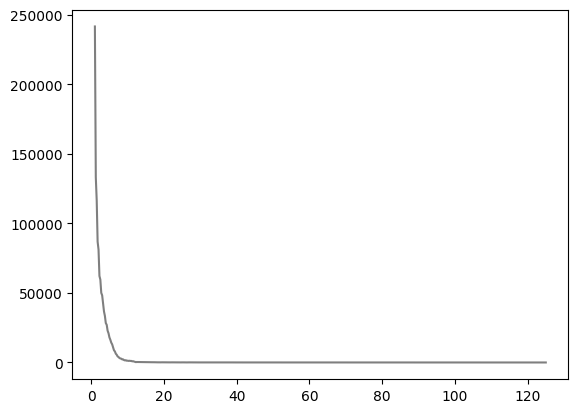

In [63]:
classifier(data_dict_list)


In [76]:
print(Y_te_global)
print(Y_te_global.shape)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]


[12, 20, 28, 44, 60, 72, 92, 112, 120, 140, 156, 172, 184, 196, 216, 224]
[12.0, 8.0, 8.0, 16.0, 16.0, 12.0, 20.0, 20.0, 8.0, 20.0, 16.0, 16.0, 12.0, 12.0, 20.0, 8.0]


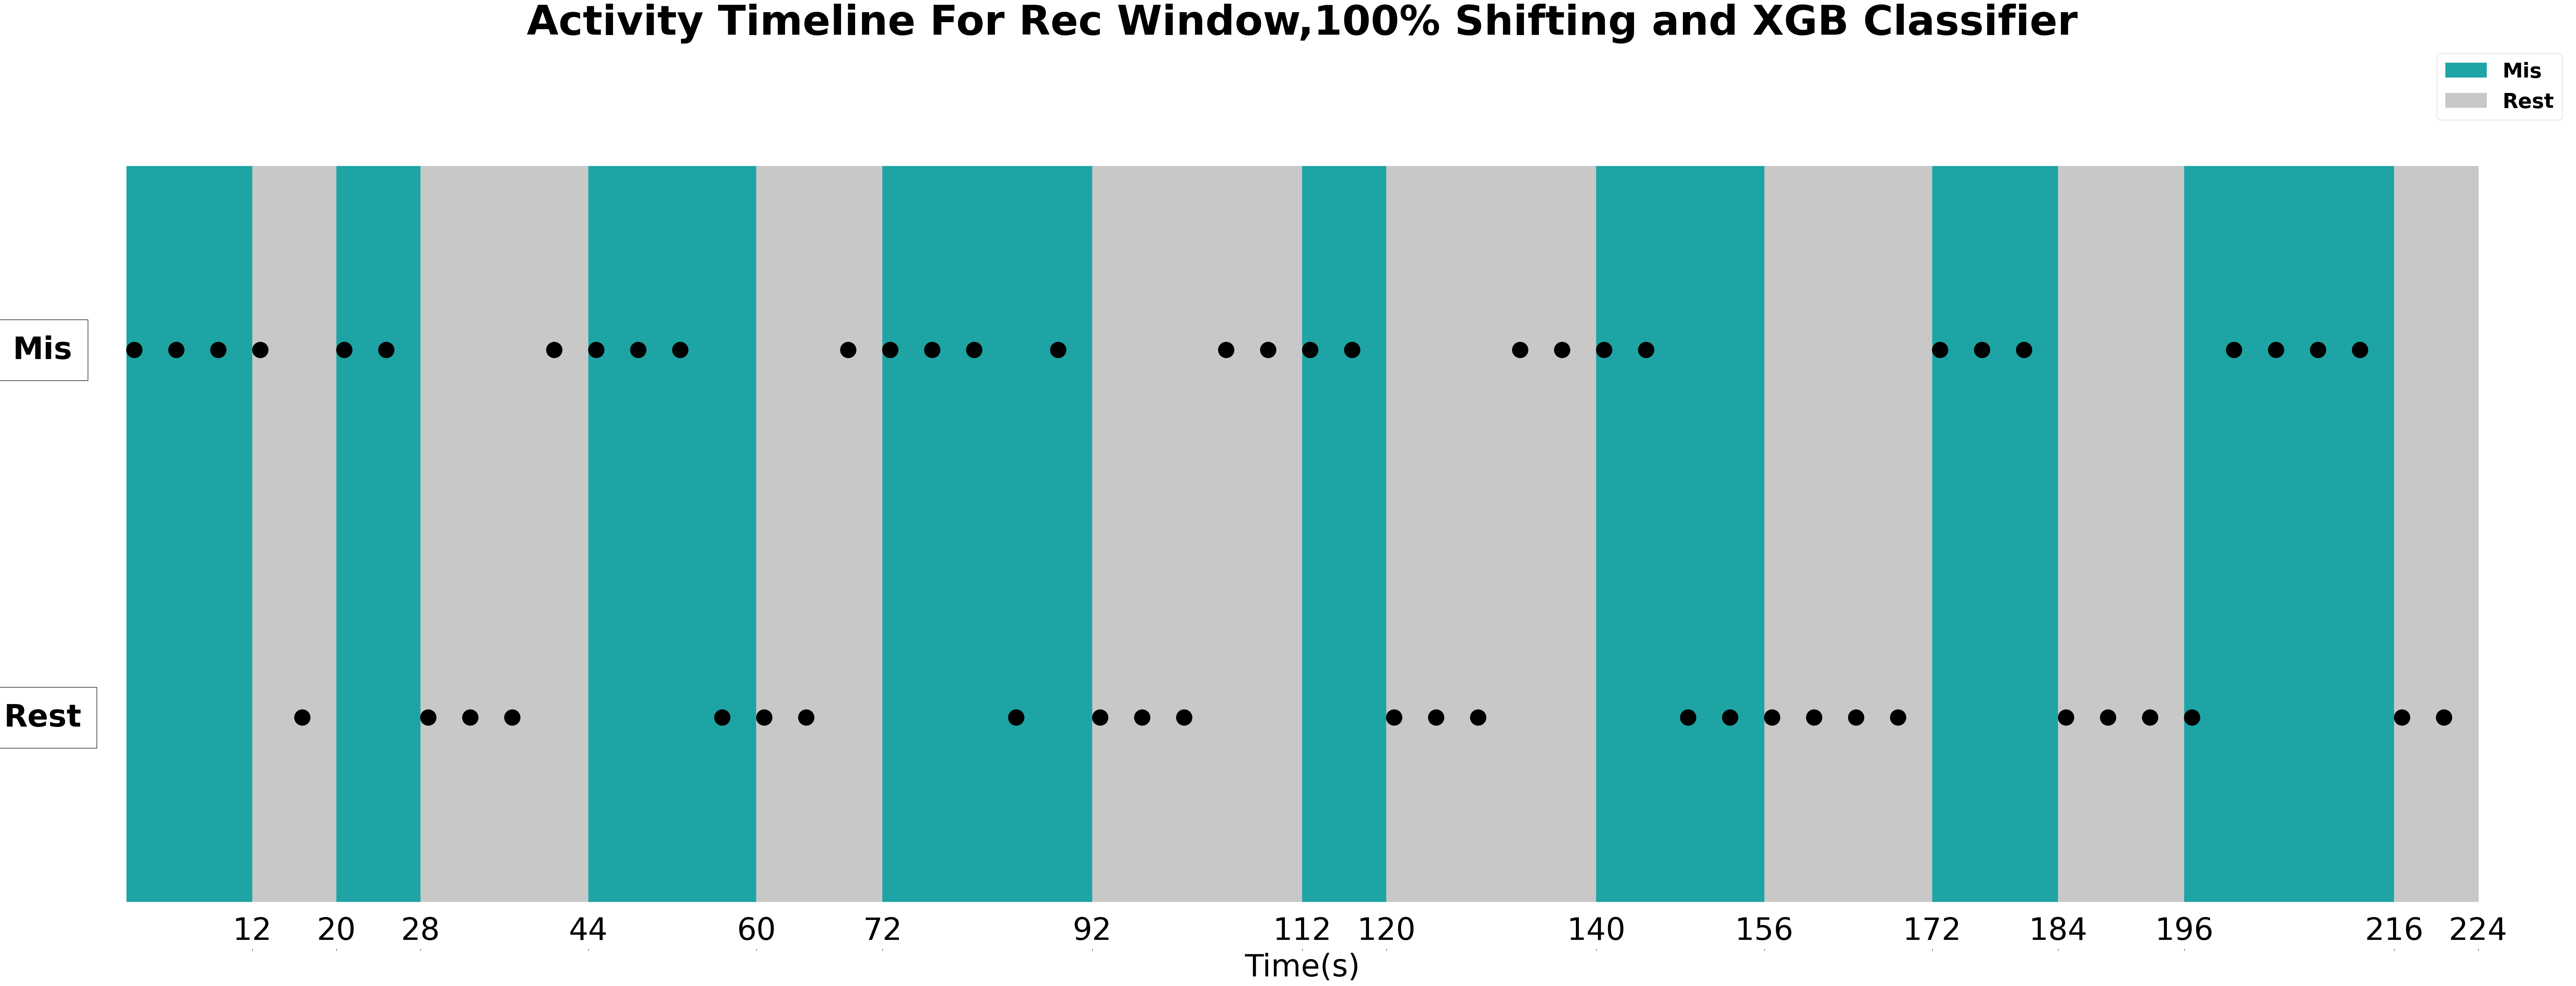

In [68]:
#without ovrlap
extra_space = 9
b_num_list = [5,6]
class_1 = "Mis"
Classifier = "XGB"
window_type = Window(0,"No_Params","Rec")
overlap_percent = 100
window_time = 4
cte = 4
accumulated_times = []
previous_time = 0
times = []
for b_num in b_num_list:
    trial_num = trial_order[b_num].index(class_1)
    task_times,rest_times = get_task_rest_times(b_num)
    trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
    times+=trial_times
res = [cte*x/window_time for x in times]

for i in times:
    current_time = previous_time + i
    accumulated_times.append(current_time)
    previous_time = current_time

print(accumulated_times)
print(res)

# Create a figure


# Define the size of the figure
fig_width = 70  # Example width
fig_height = 70  # Example height
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Add a rectangle patch for the extra space
# extra_space_rect = Rectangle((-extra_space, -extra_space), fig_width + 2 * extra_space, fig_height + 2 * extra_space, color=extra_space_color)
# ax.add_patch(extra_space_rect)

x = 0
for i, width in enumerate(res):
    color = (30/255, 164/255, 164/255) if i % 2 == 0 else (200/255, 200/255, 200/255)
    rect = Rectangle((x, 0), width, fig_height, color=color)
    ax.add_patch(rect)
    x += width



# Accumulatively add circles
total_width = sum(res)  # Total width of all rectangles
circle_size = 0.75



for index, i in enumerate(y_pr_te_global):

    if i == 1:
        circle = Circle((4*index + circle_size , 3*fig_height/4), circle_size, color='black')
    else:
        circle = Circle((4*index + circle_size , 1*fig_height/4), circle_size, color='black')

    ax.add_patch(circle)


font_prop_bold = FontProperties(weight='bold')
offset = 1
ax.text(-extra_space + offset, 3*fig_height/4, class_1, ha='center', va='center', fontsize=60, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)
ax.text(-extra_space + offset, 1*fig_height/4, 'Rest', ha='center', va='center', fontsize=60, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-extra_space, x + extra_space)
ax.set_ylim(-0.5*extra_space, fig_height + 1.3*extra_space)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



ax.set_xticks(accumulated_times)
ax.set_xticklabels([f"{int(t)}" for t in accumulated_times], fontsize=60,y=0.04)


# Add legend
legend_labels = [class_1, 'Rest']
legend_handles = [Rectangle((0, 0), 1, 1, color=(30/255, 164/255, 164/255)),
                  Rectangle((0, 0), 1, 1, color=(200/255, 200/255, 200/255))]
font_prop = FontProperties(weight='bold', size=40)

ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right', prop=font_prop, bbox_to_anchor=(1, 1))

# Set axis labels and title
ax.set_xlabel('Time(s)', fontsize=60)
ax.set_title(f'Activity Timeline For {window_type.window_name} Window,{overlap_percent}% Shifting and {Classifier} Classifier', fontsize=80, weight='bold')

# Hide the y-axis
ax.yaxis.set_visible(False)

# Show plot
plt.tight_layout()
plt.show()



# Save the figure


# Save the figure before showing
fig.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/Task-classification-chart/Corrected-pics/P09_{class_1}_2blk_Test_{window_type.window_name}_{overlap_percent}%_{Classifier}.svg', format='svg', dpi=600)

# Show the plot
# plt.show()

[12, 20, 28, 44, 60, 72, 92, 112, 120, 140, 156, 172, 184, 196, 216, 224]
[12.0, 8.0, 8.0, 16.0, 16.0, 12.0, 20.0, 20.0, 8.0, 20.0, 16.0, 16.0, 12.0, 12.0, 20.0, 8.0]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217


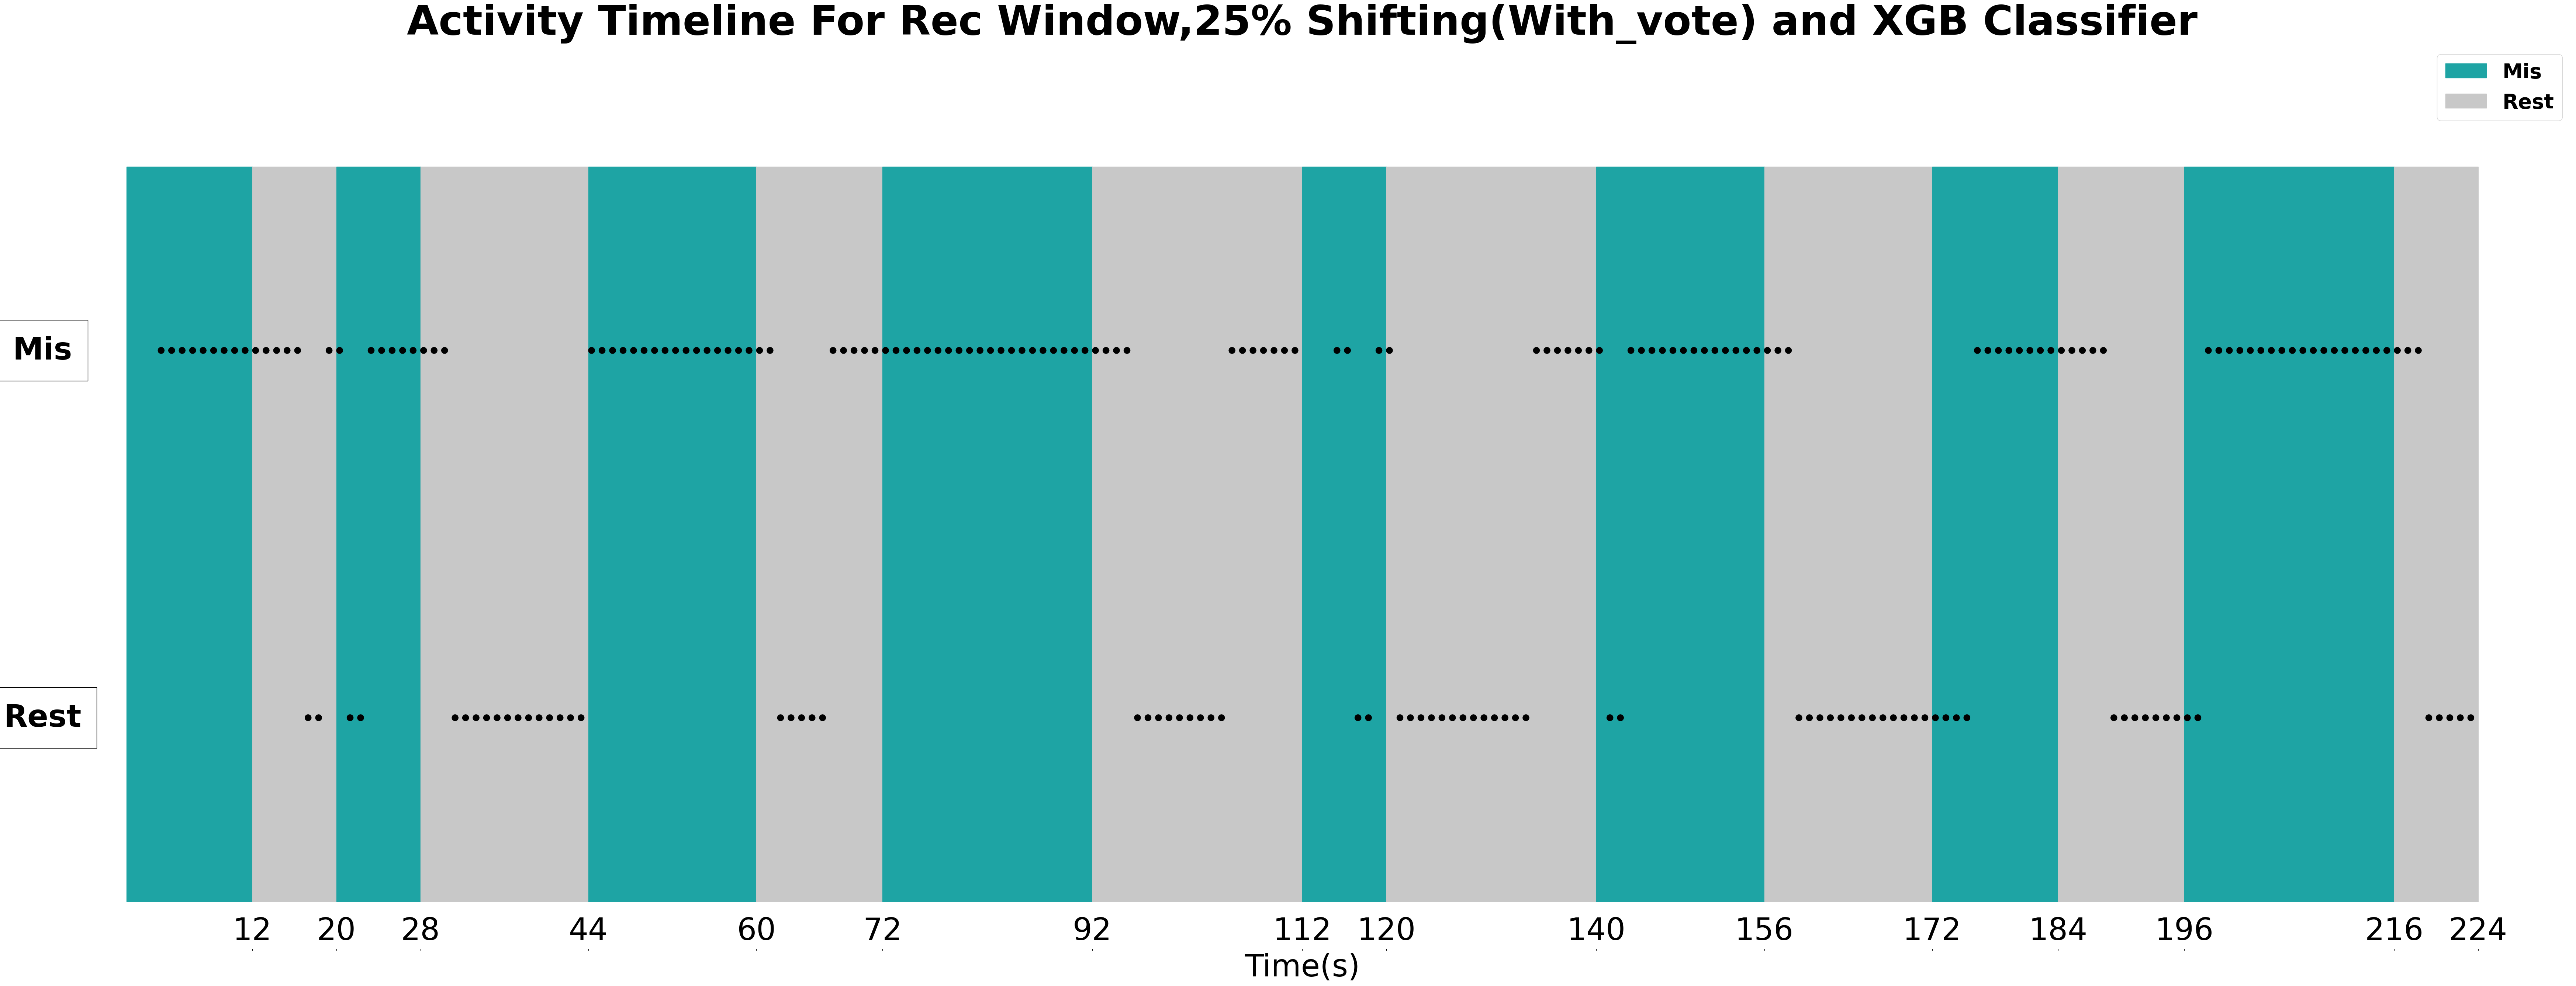

In [94]:
#For overlpap_v2

extra_space = 9
b_num_list = [5,6]
class_1 = "Mis"
Classifier = "XGB"
vote_flag = "With_vote"
window_type = Window(0,"No_Params","Rec")
overlap_percent = 25
window_time = 4
cte = 4
accumulated_times = []
previous_time = 0
times = []
for b_num in b_num_list:
    trial_num = trial_order[b_num].index(class_1)
    task_times,rest_times = get_task_rest_times(b_num)
    trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
    times+=trial_times
res = [cte*x/window_time for x in times]

for i in times:
    current_time = previous_time + i
    accumulated_times.append(current_time)
    previous_time = current_time

print(accumulated_times)
print(res)


fig_width = 70  # Example width
fig_height = 70  # Example height
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


x = 0
for i, width in enumerate(res):
    color = (30/255, 164/255, 164/255) if i % 2 == 0 else (200/255, 200/255, 200/255)
    rect = Rectangle((x, 0), width, fig_height, color=color)
    ax.add_patch(rect)
    x += width


# Accumulatively add circles

total_width = sum(res)  # Total width of all rectangles
circle_size = 0.3
for index, i in enumerate(y_pr_te_Vote_global):
    print(index)

    if index >=109:
        if i == 1:
            circle = Circle((6+index + circle_size , 3 * fig_height / 4), circle_size, color='black')
        else:
            circle = Circle((6+index + circle_size , 1 * fig_height / 4), circle_size, color='black')
    else:
        if i == 1:
            circle = Circle((3+index + circle_size , 3 * fig_height / 4), circle_size, color='black')
        else:
            circle = Circle((3+index + circle_size , 1 * fig_height / 4), circle_size, color='black')

    ax.add_patch(circle)


font_prop_bold = FontProperties(weight='bold')
offset = 1
ax.text(-extra_space + offset, 3*fig_height/4, class_1, ha='center', va='center', fontsize=60, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)
ax.text(-extra_space + offset, 1*fig_height/4, 'Rest', ha='center', va='center', fontsize=60, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-extra_space, x + extra_space)
ax.set_ylim(-0.5*extra_space, fig_height + 1.3*extra_space)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#set times
ax.set_xticks(accumulated_times)
ax.set_xticklabels([f"{int(t)}" for t in accumulated_times], fontsize=60,y=0.04)


# Add legend
legend_labels = [class_1, 'Rest']
legend_handles = [Rectangle((0, 0), 1, 1, color=(30/255, 164/255, 164/255)),
                  Rectangle((0, 0), 1, 1, color=(200/255, 200/255, 200/255))]
font_prop = FontProperties(weight='bold', size=40)
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right', prop=font_prop, bbox_to_anchor=(1, 1))

# Set axis labels and title
ax.set_xlabel('Time(s)', fontsize=60)
ax.set_title(f'Activity Timeline For {window_type.window_name} Window,{overlap_percent}% Shifting({vote_flag}) and {Classifier} Classifier', fontsize=80, weight='bold')

# Hide the y-axis
ax.yaxis.set_visible(False)

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/Task-classification-chart/Corrected-pics/P09_{class_1}_2blk_Test_{window_type.window_name}_{overlap_percent}%_{Classifier}_{vote_flag}.svg', format='svg', dpi=600)





In [79]:
print("Hi")
print(Y_te_global)

Hi
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [

In [67]:
from functools import partial
def classifier_multiprocess(data_dicts_list):
    classifier_dic = {"XGB": XGBClassifier(n_jobs = 32), "LDA": LDA()}
    number_of_components_list = [10]
    number_of_selected_features_list = [10, 2]
    overlap_percent_list = [100, 25]
    channels_to_remove = []
    number_of_channels = NUMBER_OF_CHANNELS
    window_time_length_list = [4]
    sliding_time_tr = 4
    sliding_time_te = 4
    vote_window = 3
    window_type_list = ["Rec", "Kaiser"]
    train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
    test_blk_set_dic = {"67": [5, 6], "567": [4, 5, 6], "4567": [3, 4, 5, 6], "34567": [2, 3, 4, 5, 6],
                        "234567": [1, 2, 3, 4, 5, 6]}
    class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
    class_2 = 'Rest'
    p_num_list = [3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
    PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"

    pool = multiprocessing.Pool()

    # Create a partial function with fixed arguments
    partial_process = partial(process_configuration, data_dicts_list=data_dicts_list, class_1_list=class_1_list,
                               class_2=class_2)

    # Generate all configurations to process
    configurations = [(classifier_name, number_of_components, number_of_selected_features, overlap_percent,
                        window_time_length, window_type, train_blk_set, test_blk_set, p_num)
                       for classifier_name in classifier_dic.keys()
                       for number_of_components in number_of_components_list
                       for number_of_selected_features in number_of_selected_features_list
                       for overlap_percent in overlap_percent_list
                       for window_time_length in window_time_length_list
                       for window_type in window_type_list
                       for train_blk_set, train_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys())
                       for test_blk_set, test_blk_name in zip(test_blk_set_dic.values(), test_blk_set_dic.keys())
                       for p_num in p_num_list]

    # Use multiprocessing to process the configurations
    pool.starmap(partial_process, configurations)

    pool.close()
    pool.join()


if __name__ == "__main__":
    # Example usage
    classifier_multiprocess(data_dict_list)

Process ForkPoolWorker-49:
Process ForkPoolWorker-60:
Process ForkPoolWorker-61:
Process ForkPoolWorker-55:
Process ForkPoolWorker-53:
Process ForkPoolWorker-38:
Process ForkPoolWorker-51:
Process ForkPoolWorker-62:


KeyboardInterrupt: 

Process ForkPoolWorker-63:
Process ForkPoolWorker-64:
Process ForkPoolWorker-50:
Process ForkPoolWorker-52:
Process ForkPoolWorker-59:
Process ForkPoolWorker-46:
Process ForkPoolWorker-57:
Process ForkPoolWorker-42:
Process ForkPoolWorker-45:
Process ForkPoolWorker-65:
Process ForkPoolWorker-67:
Process ForkPoolWorker-66:
Process ForkPoolWorker-58:
Process ForkPoolWorker-68:
Process ForkPoolWorker-44:
Process ForkPoolWorker-41:
Process ForkPoolWorker-40:
Process ForkPoolWorker-39:
Process ForkPoolWorker-48:
Process ForkPoolWorker-43:
Process ForkPoolWorker-54:
Process ForkPoolWorker-56:
Process ForkPoolWorker-47:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call l

## Data Visualization

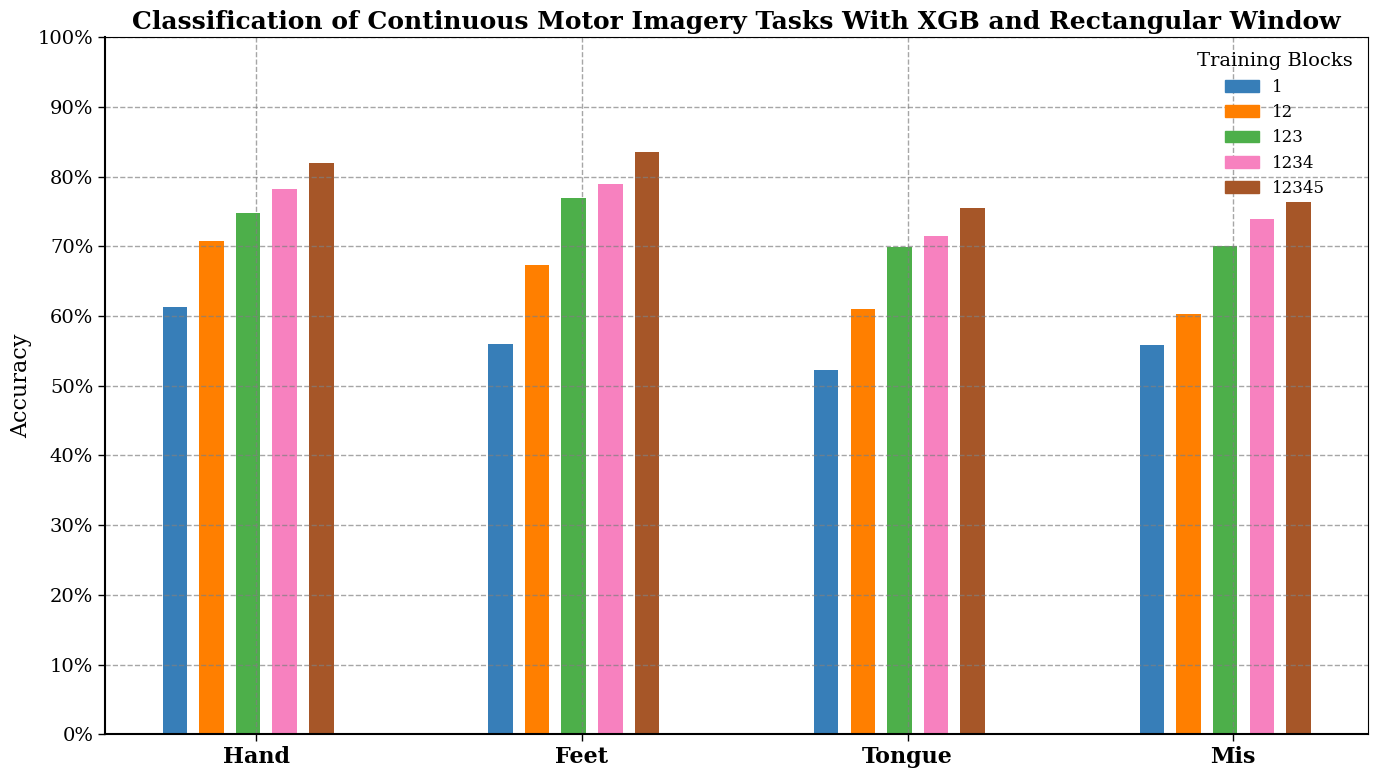

In [11]:
# Define a more visually appealing and colorblind-friendly color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628']
train_blk_set_dic = {"1": colors[0], "12": colors[1], "123": colors[2], "1234": colors[3], "12345": colors[4]}

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis']
labels_to_x = {'Hand': 1, 'Feet': 2, 'Tongue': 3, 'Mis': 4}

x = [labels_to_x[label] * 4 for label in labels]
x = np.array(x)

PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
classifier_name = "XGB"
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Window(0,"No_Params","Rec")
train_blk_list = [1, 12, 123, 1234, 12345]
bar_width = 0.3
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust figure size as needed

# Generate legend patches with the new color palette
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

for index, (train_blk, color) in enumerate(train_blk_set_dic.items()):
    acc_list_1 = return_acc(PATH, classifier_name, number_of_components, number_of_selected_features, overlap_percent, window_time_length, window_type, train_blk)
    blk_values = acc_list_1
    ax.bar(x + index * bar_width * 1.5, blk_values, width=bar_width, color=color)

# Enhance font readability
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'  # Consider using 'Times New Roman' or 'Arial' for academic papers

# Refine axis for readability
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Enhance ticks for clarity
ax.tick_params(axis='x', colors='black', direction='out', length=5, width=1)
ax.tick_params(axis='y', colors='black', direction='out', length=5, width=1)

# Set x ticks and labels with refined font settings
ax.set_xticks(x+1)
ax.set_xticklabels(labels, fontsize=16, fontweight='bold')

# Set y ticks and labels with refined font settings and add accuracy label to y-axis
y_ticks = np.linspace(0, 1, 11)  # Adjust range and number of ticks as needed
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{int(val * 100)}%' for val in y_ticks], fontsize=14)
ax.set_ylabel('Accuracy', fontsize=16)  # Adding accuracy label to the y-axis

# Refine grid lines for better visibility
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.7, linewidth=1)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7, linewidth=1)

# Add legend and title with enhanced appearance
ax.legend(legend_patches, train_blk_set_dic.keys(), fontsize=12, title='Training Blocks', title_fontsize='14', frameon=False)
ax.set_title('Classification of Continuous Motor Imagery Tasks With XGB and Rectangular Window', fontsize=18, fontweight='bold', family='serif')  # Adjust title

plt.tight_layout()  # Adjust layout for better fit
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/EEG-Ground/{classifier_name}_{number_of_selected_features}SF_{window_type.window_name}_{window_type.param_name}_{window_type.param_value}_{overlap_percent}%.jpg', dpi=300, bbox_inches='tight')

plt.show()

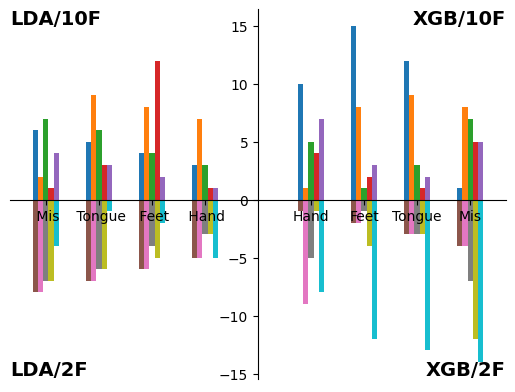

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis', ' Hand', ' Feet', ' Tongue', ' Mis']
labels_to_x = {'Hand':1, 'Feet':2, 'Tongue':3, 'Mis':4, ' Hand':-1, ' Feet':-2, ' Tongue':-3, ' Mis':-4}

# Convert categories to numerical x-values
x = [labels_to_x[label] for label in labels]
x = np.array(x)

# Values for different groups
blk1_values_10F = [10, 15, 12, 1, 3, 4, 5, 6]
blk12_values_10F = [1, 8, 9, 8, 7, 8, 9, 2]
blk123_values_10F = [5, 1, 3, 7, 3, 4, 6, 7]
blk1234_values_10F = [4, 2, 1, 5, 1, 12, 3, 1]
blk12345_values_10F = [7, 3, 2, 5, 1, 2, 3, 4]

blk1_values_2F = [1, 2, 3, 4, 5, 6, 7, 8]
blk12_values_2F = [9, 2, 3, 4, 5, 6, 7, 8]
blk123_values_2F = [5, 1, 3, 7, 3, 4, 6, 7]
blk1234_values_2F = [1, 4, 3, 12, 3, 5, 6, 7]
blk12345_values_2F = [8, 12, 13, 14, 5, 2, 1, 4]

# Set the width of the bars within each group
bar_width = 0.1

# Create a figure and axis
fig, ax = plt.subplots()

# Create the bar charts for all five groups side by side using ax.bar
ax.bar(x - 2*bar_width, blk1_values_10F, width=bar_width, label='blk1 10F')
ax.bar(x - bar_width, blk12_values_10F, width=bar_width, label='blk2 10F')
ax.bar(x, blk123_values_10F, width=bar_width, label='blk3 10F')
ax.bar(x + bar_width, blk1234_values_10F, width=bar_width, label='blk4 10F')
ax.bar(x + 2*bar_width, blk12345_values_10F, width=bar_width, label='blk5 10F')

ax.bar(x - 2*bar_width, [-i for i in blk1_values_2F], width=bar_width, label='blk1 2F')
ax.bar(x - bar_width, [-i for i in blk12_values_2F], width=bar_width, label='blk2 2F')
ax.bar(x, [-i for i in blk123_values_2F], width=bar_width, label='blk3 2F')
ax.bar(x + bar_width, [-i for i in blk1234_values_2F], width=bar_width, label='blk4 2F')
ax.bar(x + 2*bar_width, [-i for i in blk12345_values_2F], width=bar_width, label='blk5 2F')

# Axis adjustments
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xticks(x)
ax.set_xticklabels(labels)


# Adding custom section titles
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Top left (B)
ax.text(xlims[0], ylims[1], 'LDA/10F', horizontalalignment='left', verticalalignment='top', fontsize=14, weight='bold')

# Top right (A)
ax.text(xlims[1], ylims[1], 'XGB/10F', horizontalalignment='right', verticalalignment='top', fontsize=14, weight='bold')

# Bottom left (C)
ax.text(xlims[0], ylims[0], 'LDA/2F', horizontalalignment='left', verticalalignment='bottom', fontsize=14, weight='bold')

# Bottom right (D)
ax.text(xlims[1], ylims[0], 'XGB/2F', horizontalalignment='right', verticalalignment='bottom', fontsize=14, weight='bold')

# Show the plot
plt.show()


AttributeError: 'str' object has no attribute 'window_name'

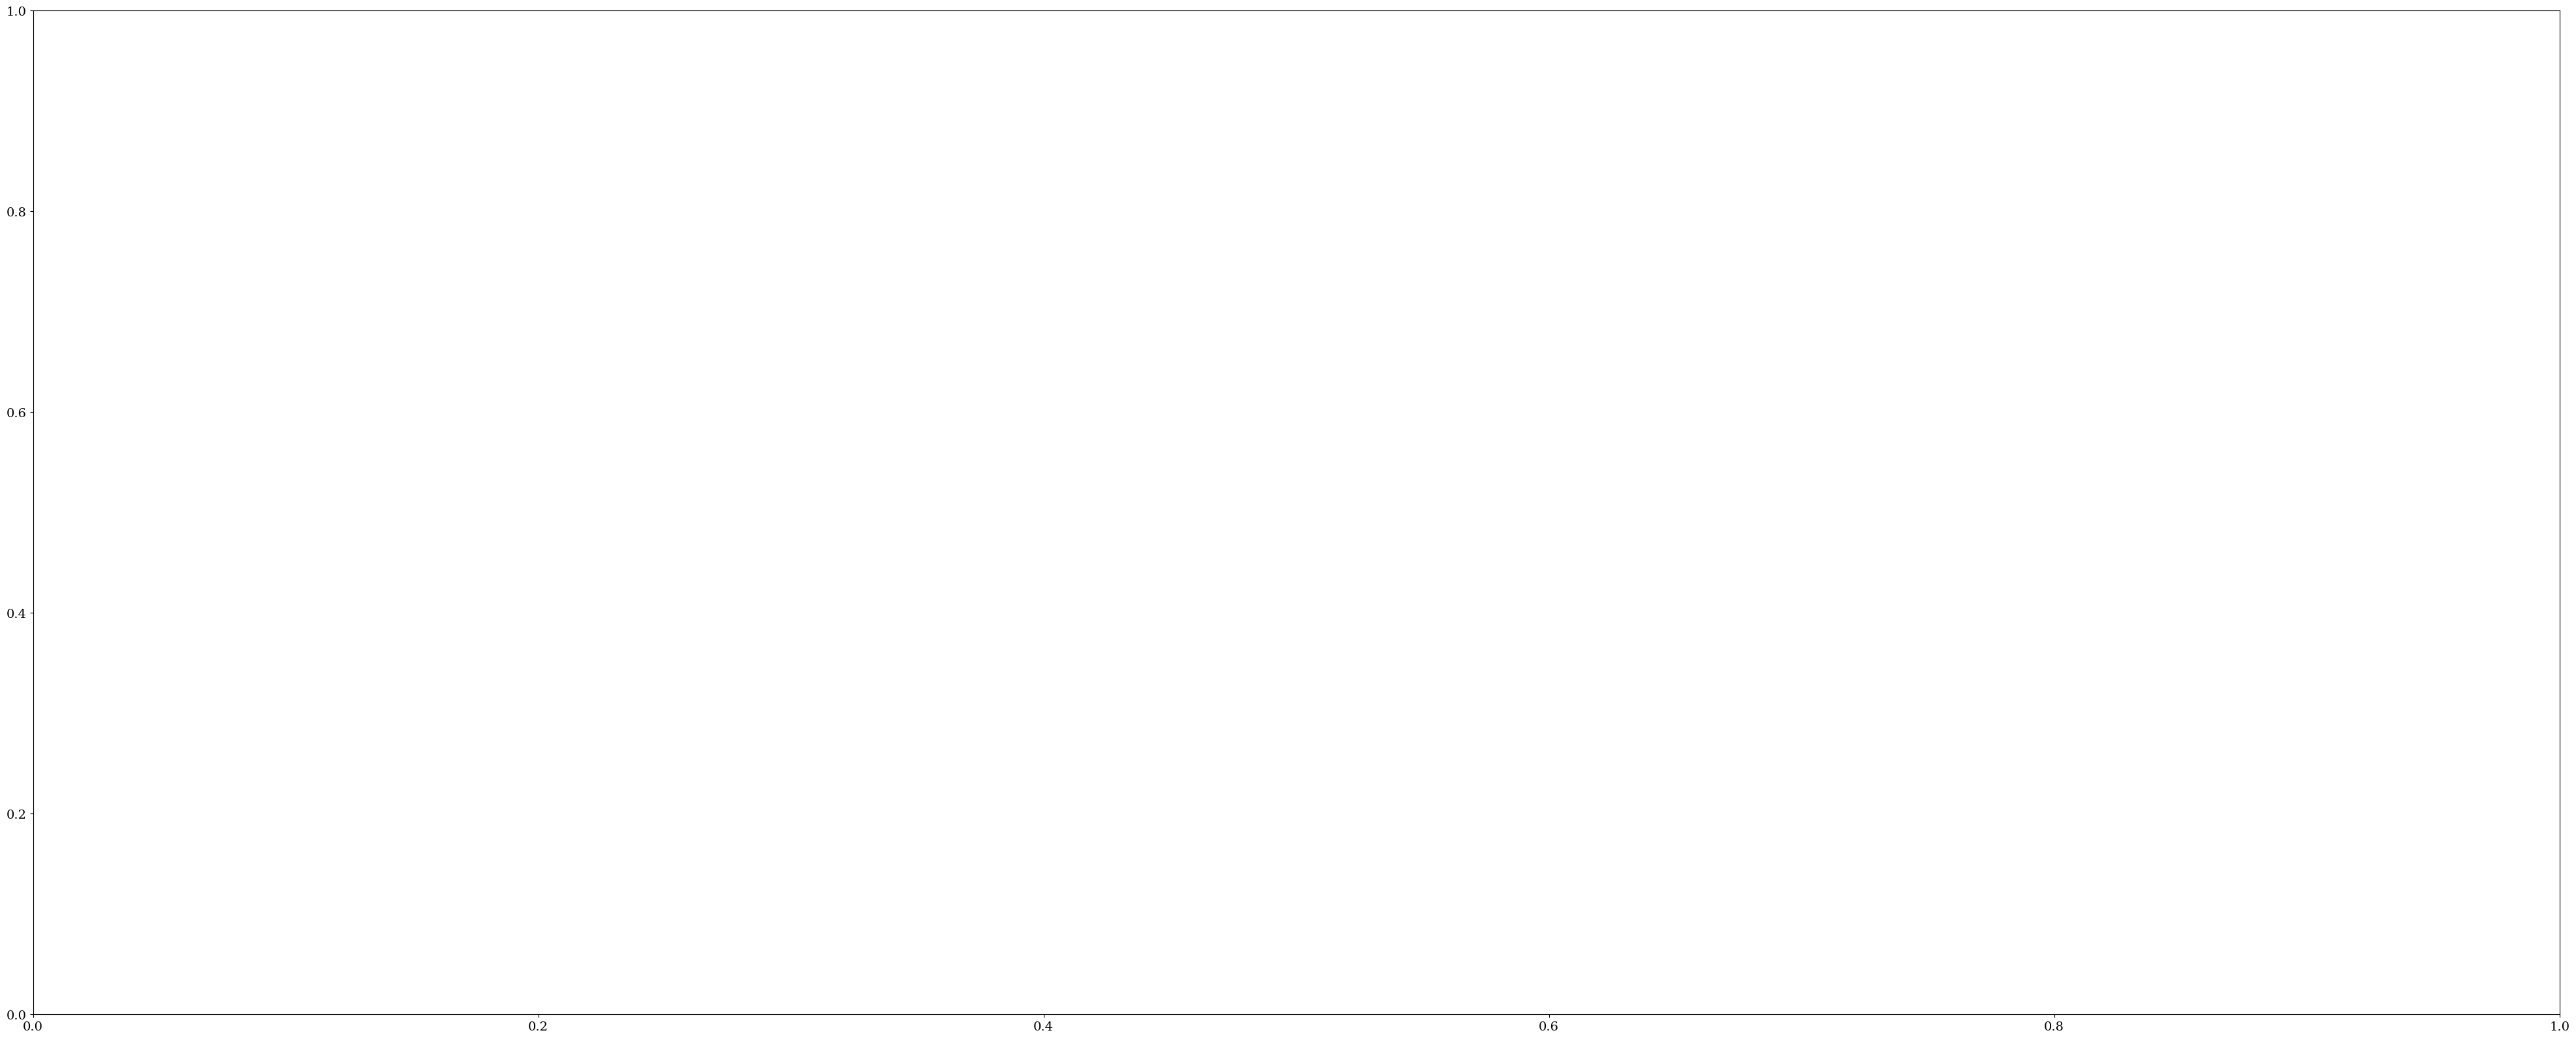

In [55]:
# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis', ' Hand', ' Feet', ' Tongue', ' Mis']
labels_to_x = {'Hand':1, 'Feet':2, 'Tongue':3, 'Mis':4, ' Hand':-1, ' Feet':-2, ' Tongue':-3, ' Mis':-4}




x = [labels_to_x[label]*4 for label in labels]
x = np.array(x)



PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
classifier_name = "XGB"
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 25
window_time_length = 4
window_type = "Rec"

train_blk_set_dic = {"1":"red","12":"blue","123":"green","1234":"orange","12345":"grey"}
n = len(train_blk_list)
m = list(range(-(n-1)//2, (n-1)//2 + 1))
# train_blk_list = ["12345","1234","123","12","1"]
number_of_selected_features_list = [10,2]
bar_width = 0.3
fig, ax = plt.subplots(figsize=(50, 20))

legend_labels = ['b1', 'b12', 'b123', 'b1234', 'b12345']
colors = train_blk_set_dic.values()
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
for number_of_selected_features in number_of_selected_features_list:
    for index, (train_blk, color) in enumerate(zip(train_blk_set_dic.keys(), train_blk_set_dic.values())):
        classifier_name = "XGB"
        acc_list_1 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        classifier_name = "LDA"
        acc_list_2 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        blk_values = acc_list_1 + acc_list_2
        print(blk_values)
        if number_of_selected_features == 2:
            blk_values = [-j for j in blk_values]
            
        ax.bar(x + m[index]*bar_width*1.5, blk_values, width=bar_width, color=color)



ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=40)
ax.set_yticklabels(ax.get_yticks(), fontsize=40)  # Adjust the fontsize as needed

y_max = max(ax.get_yticks())
y_ticks = [i*10/100  for i in range(-10,11)]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{float(val)}%' for val in y_ticks], fontsize=20)
ax.grid(True, linestyle='--')

# y_ticks = ax.get_yticks()
# y_max = max(y_ticks)
# for i in range(1, 10):
#     y_value = i / 10 * y_max
#     ax.axhline(y=y_value, color='gray', linestyle='--')
ax.legend(legend_patches, legend_labels, fontsize=20, title='Legend')
ax.set_title(f'{window_type}_{overlap_percent}%', fontsize=40, weight='bold')






xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Top left (B)
ax.text(xlims[0], ylims[1], 'LDA/10F', horizontalalignment='left', verticalalignment='top', fontsize=40, weight='bold')

# Top right (A)
ax.text(xlims[1], ylims[1], 'XGB/10F', horizontalalignment='right', verticalalignment='top', fontsize=40, weight='bold')

# Bottom left (C)
ax.text(xlims[0], ylims[0], 'LDA/2F', horizontalalignment='left', verticalalignment='bottom', fontsize=40, weight='bold')

# Bottom right (D)
ax.text(xlims[1], ylims[0], 'XGB/2F', horizontalalignment='right', verticalalignment='bottom', fontsize=40, weight='bold')

# Show the plot
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/{window_type}_{overlap_percent}%.svg', dpi=300, bbox_inches='tight')
plt.show()



In [5]:
def return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk_name):

    path = os.path.join(
    PATH,
    classifier_name,
    f"{number_of_components}_CSP_Components",
    f"{number_of_selected_features}-Selected_Features",
    f"{overlap_percent}%_Overlap",
    f"{window_time_length}_window_time_length",
    f"{window_type.window_name}_Window",
    f"{window_type.param_name}",
    f"{window_type.param_value}_{window_type.param_name}",
    f"{train_blk_name}_Train/"
    )   

    data_dic = {path:pd.read_csv(path+"AverageAcc.csv")}
    acc = list(data_dic[path]['test_acc'])
    return acc


In [ ]:
n =7
m = list(range(-(n-1)//2, (n-1)//2 + 1))
print(m)

[-3, -2, -1, 0, 1, 2, 3]


# Side Analysis

In [38]:
# #Frame Maker
PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v4/XGB/"
df = pd.read_csv(PATH+'frame.csv')
p_num_list = [3,4,5,6,7,9,10,11,13,14,15]
for p_num in p_num_list:
    df.to_csv(PATH+'P'+str(p_num)+'.csv',index=False)



In [ ]:
path = os.path.join(
    PATH,
    classifier_name,
    f"{number_of_components}_CSP_Components",
    f"{number_of_selected_features}-Selected_Features",
    overlapflag,
    f"{window_time_length}_window_time_length",
    f"{window_type}_Window",
    f"{train_blk_name}_Train/",
)
print(path + f"P{p_num}.csv")

In [ ]:
import pandas as pd

def save_csv(new_row, classifier, number_of_components, number_of_selected_features, overlapflag,
             window_time_length, window_type, train_blk_name, p_num):
    # Convert to relative path
    relative_path = os.path.join(
        classifier,
        f"{number_of_components}_CSP_Components",
        f"{number_of_selected_features}-Selected_Features",
        overlapflag,
        f"{window_time_length}_window_time_length",
        window_type,
        f"{train_blk_name}_Train",
        f"P{p_num}.csv"
    )

    # Convert relative path to absolute path
    absolute_path = os.path.abspath(relative_path)

    # Read existing CSV or create an empty DataFrame
    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    # Create a new row DataFrame
    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)

    # Concatenate existing DataFrame and new row DataFrame
    cf = pd.concat([rf, new_row_df], ignore_index=True)

    # Write the concatenated DataFrame to CSV
    cf.to_csv(absolute_path, index=False)

# Example usage
classifier = "XGBClassifier"
number_of_components = 10
number_of_selected_features = 10
overlapflag = "With_Overlap"
window_time_length = "4_window_time_length"
window_type = "50% Overlap"
train_blk_name = "12345"
p_num = 9

new_row = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10]
save_csv(new_row, classifier, number_of_components, number_of_selected_features, overlapflag,
         window_time_length, window_type, train_blk_name, p_num)


In [ ]:

# # Specific path and file name
# file_path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/frame.csv'  # Replace with your specific path
# df = pd.DataFrame(columns=column_names)
# # Write the DataFrame to a CSV file at the specified path
# df.to_csv(file_path, index=False)

In [ ]:
first_list = ["12345", "1234", "123", "12", "1"]

second_list = []

for item in first_list:
    result = ""
    for i in range(len(item) - 1):
        result += str(int(item[i]) + int(item[i + 1]))
    second_list.append(result)

print(second_list)


In [ ]:
train_blk_set_dic = {"01234":[0,1,2,3,4],"0123":[0,1,2,3],"012":[0,1,2],"01":[0,1],"0":[0]}
for train_blk_set,train_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys()):
    print(len(train_blk_set))
    print(train_blk_name)

In [ ]:
def remove_outliers(df):
    # Specify the threshold for outliers (you can adjust this based on your data)
    threshold = 10 ** 5

    # Calculate median and MAD for each row
    median = df.iloc[:, :-1].median(axis=1)
    mad = np.median(np.abs(df.iloc[:, :-1].sub(median, axis=0)), axis=1)
    threshold_array = median + threshold * mad

    # Identify rows with values exceeding the threshold
    outliers = df.iloc[:, :-1].gt(threshold_array[:, None], axis=0).any(axis=1)

    # Remove rows identified as outliers
    clean_df = df[~outliers]

    return clean_df


In [35]:

#Pikle_converter
def data_reader(path,p_num,block_list):
    data_dict = {}
    for b_num in block_list:
        print(b_num)
        mat = loadmat(path+'P'+ str(p_num) + '/'+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
        df = pd.DataFrame(mat['Data'])
        df.to_pickle(f"{path}Pickels_Participants/P{p_num}/P{p_num}B{b_num}.pkl")
    #     data_dict[b_num] = df
    # return data_dict

In [36]:
block_list = [0,1,2,3,4,5,6]
p_num_list = [15]
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/'
for p_num in p_num_list:
    print("reading",p_num)
    data_reader(path,p_num,block_list)



reading 15
0
1
2
3
4
5
6


In [1]:
print("hi")

hi


In [ ]:
from scipy import stats

def remove_outliers_across_channels(df, threshold):
    # print(df.shape,"shape0")

    data_columns = df.columns[:-1]  # Excluding the label column by default

    # Separate the label column
    labels = df.iloc[:, -1]  # Assuming the label is in the last column
    data_without_label = df.iloc[:, :-1]  # DataFrame without the label column

    # Calculate Z-scores for each row
    # print(data_without_label.shape,"shape1")
    # print(data_without_label[data_columns].shape,"shape2")
    # print(data_without_label.head(10))
    data_without_label[data_columns] = data_without_label[data_columns].apply(pd.to_numeric, errors='coerce')
    z_scores = stats.zscore(data_without_label[data_columns], axis=1)
    abs_z_scores = abs(z_scores)

    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    filtered_data = data_without_label[filtered_entries]

    # Remove corresponding labels for removed rows
    filtered_labels = labels[filtered_entries]

    # If you want to reset index after filtering
    filtered_data.reset_index(drop=True, inplace=True)
    filtered_labels.reset_index(drop=True, inplace=True)

    # Combine the filtered data and labels
    filtered_df = pd.concat([filtered_data, filtered_labels], axis=1)

    return filtered_df


In [ ]:
prediction_list = [1, 1, 1, 1, 0, 0, 1, 1, 0, 0]  # Replace with your actual prediction list

result = majority_vote_sliding_with_next(prediction_list)
result2 = majority_vote_sliding_with_prev_v2(prediction_list)
print("Majority Votes:", result)
print("Majority Votes Previous:", result2)

## Getting Average

In [ ]:
PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/Win4Shift2/'
p_num_list = [3,4,5,6,7,9,10,11,13,14]
vf = pd.DataFrame(columns=column_names_v2) 
for p_num in p_num_list:
    print(p_num)
    rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
    vf = pd.concat([vf, rf], ignore_index=True)
vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)
# vf.tail()
    
columnNames = ['class','test_acc','vote_acc']
kf = pd.DataFrame(columns=columnNames)
kf.to_csv(PATH+'AverageAcc.csv',index=False)

vf = pd.read_csv(PATH +"ResultsOfAll.csv")
df = vf

class_list=['Hand','Feet','Tongue','Mis']
blk_list = [1234]
for class_ in class_list:
    avg_list = []
    avg_vote_list = []
    for blk in blk_list:
        gf = df[(df['train_block'] == blk) & (df['class1'] == class_)]
        avg = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean()
        avg_list.append(avg)
        avg_vote_list.append(avg_vote)
    print(avg_list)    
    new_row = [class_, avg_list[0],avg_vote_list[0]] 
    new_row_df = pd.DataFrame([new_row], columns=columnNames)
    rf = pd.read_csv(PATH + 'AverageAccExcP8.csv')
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(PATH +'AverageAccExcP8.csv',index=False)  
kf = pd.read_csv(PATH +'AverageAccExcP8.csv') 
kf.head()

In [ ]:
# Assuming df is your DataFrame with the last column named 'label'
data = {'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter'],
        'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b']}

df = pd.DataFrame(data)

print(df)
print("his")
# Define a custom sorting order based on the desired grouping
sorting_order = {'a': 0, 'b': 1}

# Create a new column with the sorting order
df['sorting_order'] = df.iloc[:, 2].map(sorting_order)

# Sort the DataFrame based on the new column and the original order within each group
df.sort_values(by=['sorting_order', df.columns[2]], inplace=True)

# Drop the temporary sorting column
df.drop('sorting_order', axis=1, inplace=True)

# Optional: Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(df)





In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter','b'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b','b']
}

df = pd.DataFrame(data)

x=0
i=0
class_1 = 'a'
class_2 = 'b'
sampleList = []
while i<len(df):
    if (df.iloc[i,2]==class_1):
        x+=1
    else:
        i-=1
        sampleList.append(x)
        x=0
        class_1,class_2 = class_2,class_1
    i+=1
sampleList.append(x)
print(sampleList)

In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'it', 'does', 'not matter'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'b', 'b', 'b']
}
df = pd.DataFrame(data)

print(get_group_start_indices(df))


In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter','c'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b','b']
}

df = pd.DataFrame(data)

# Identify consecutive groups of 'a's by creating a new group ID each time 'label' changes from 'b' to 'a'
df['group'] = (df['label'] != df['label'].shift(1)).cumsum()

# Count occurrences of 'a' within each group
group_counts = df[df['label'] == 'a'].groupby('group').size()

group_counts_b = df[df['label'] == 'b'].groupby('group').size()
print(group_counts_b)
print(group_counts_b.index[0])
print(group_counts_b.iloc[0])
print(group_counts)

In [ ]:
p_num = 8
b_num = 7
path = f'../../Participants/P{p_num}v5/'
mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
df = pd.DataFrame(mat['Data'])

path = f'../../Participants/P{p_num}v0/'
mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
df_1 = pd.DataFrame(mat['Data'])

print(df.shape)
print(df_1.shape)


In [ ]:
from skimage.filters import median

def apply_median_filter(df, window_size=10):
    channel_data = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values 
    filtered_channel_data = np.zeros_like(channel_data) 

    for i in range(channel_data.shape[1]):
        print(i,"channel")
        filtered_channel_data[:, i] = median(channel_data[:, i], selem=np.ones(window_size))

    df_filtered = pd.DataFrame(filtered_channel_data, columns=df.columns[:-1])
    df_filtered['Label'] = labels
    print(df_filtered.shape, "shape after median filter")

    return df_filtered


In [90]:
def apply_pca(train_data, test_data=None, n_components=50):
    # Reshape train data

    train_data = mne.filter.filter_data(train_data, sampling_freq, 0, 0 + 36, verbose = False, n_jobs = 4)
    test_data = mne.filter.filter_data(test_data, sampling_freq, 0, 0 + 36, verbose = False, n_jobs = 4)
        
    train_data_reshaped = np.reshape(train_data, (train_data.shape[0], -1))


    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data_reshaped)
    # scaled_train_data = train_data_reshaped
    
    # Apply PCA on train data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_train_data)
    transformed_train_data = pca.transform(scaled_train_data)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)
    print("\nCumulative Explained Variance:")
    print(cumulative_explained_variance)


    test_data_reshaped = np.reshape(test_data, (test_data.shape[0], -1))
    scaled_test_data = scaler.transform(test_data_reshaped)
    transformed_test_data = pca.transform(scaled_test_data)

    return transformed_train_data, transformed_test_data


In [ ]:
extra_samples_block_counter(df_1,trial_order[0])

In [ ]:
for b in range(7):
    extra_samples_block_counter(data_dicts_list[-1][b],trial_order[b],b)

## SCSSP

In [3]:

def nf_band_pass_filter(type_one, type_two, fs):
    # Define the frequency bands
    frequency = np.array([[4, 8], [8, 12], [12, 16], [16, 20]])
    print(frequency.shape)
    print(len(frequency),"len(frequency)")
    # Sampling frequency
    fs = fs
    filt_n = 2
    wn = np.array([x/(fs/2) for x in frequency])
    # wn = frequency[f] / (fs / 2)
    print(wn)

    # Preallocate filtered data arrays
    print(type_one.shape,"type_one shape")
    f_type_one = np.zeros_like(type_one)
    f_type_two = np.zeros_like(type_two)
    data_filter = np.zeros((len(frequency), type_one.shape[0], type_one.shape[1]))

    print(f_type_two.shape,"f_type_two")

    # Step 1: Applying Causal Chebyshev Type II Filter to each EEG Epoch
    for f in range(len(frequency)):
        print(wn[f])
        filter_b, filter_a = cheby2(filt_n * 2, 60, wn[f], 'bandpass')
        # Apply the filter to the data - using filtfilt for zero-phase filtering
        data_filter[f, :, :] = filtfilt(filter_b, filter_a, type_one, axis=1)
        f_type_one = data_filter[:,:,:]
        data_filter[f, :, :] = filtfilt(filter_b, filter_a, type_two, axis=1)
        f_type_two = data_filter[:,:,:]

    return f_type_one, f_type_two

In [4]:
def covariance(f_type_one, f_type_two):
    # Transposing 3D matrix
    type_one_t = np.transpose(f_type_one, (1, 0, 2))
    type_two_t = np.transpose(f_type_two, (1, 0, 2))

    # Dimensions
    Nch = f_type_one.shape[1]  # Number of channels
    Nf = f_type_one.shape[0]  # Number of frequency bands
    Nt = f_type_one.shape[2]  # Number of time samples

    # Initialize covariance matrices
    spe = 0
    spa = 0

    # Calculate the spatial & spectral covariance for fTypeOne
    for j in range(f_type_one.shape[2]):
        # Spectral covariance
        spe1 = np.dot(f_type_one[:, :, j], type_one_t[:, :, j])
        spe += spe1

        # Spatial covariance
        spa1 = np.dot(type_one_t[:, :, j], f_type_one[:, :, j])
        spa += spa1

    # Spectral covariance
    c_type_one_spectral = (1 / (Nf * Nt)) * spe
    # Spatial covariance
    c_type_one_spatial = (1 / (Nch * Nt)) * spa

    # Reset for fTypeTwo
    spe = 0
    spa = 0

    # Calculate the spatial & spectral covariance for fTypeTwo
    for j in range(f_type_two.shape[2]):
        # Spectral covariance
        spe1 = np.dot(f_type_two[:, :, j], type_two_t[:, :, j])
        spe += spe1

        # Spatial covariance
        spa1 = np.dot(type_two_t[:, :, j], f_type_two[:, :, j])
        spa += spa1

    # Spectral covariance
    c_type_two_spectral = (1 / (Nf * Nt)) * spe
    # Spatial covariance
    c_type_two_spatial = (1 / (Nch * Nt)) * spa

    return c_type_one_spectral, c_type_one_spatial, c_type_two_spectral, c_type_two_spatial

In [5]:
def eigenvalues_problem(c_type_one_spectral, c_type_one_spatial, c_type_two_spectral, c_type_two_spatial, f_type_one, f_type_two, d):
    Nch = c_type_one_spatial.shape[0]
    Nf = c_type_one_spectral.shape[0]
    print(Nch,"Nch")
    print(Nf,"Nf")
    lambda_m = np.zeros((Nf, Nch))
    lambda_n = np.zeros((Nf, Nch))

    # Spatial Eigenvalues
    wr1, vr1 = np.linalg.eig(np.linalg.solve(c_type_one_spatial, c_type_one_spatial + c_type_two_spatial))
    wr2, vr2 = np.linalg.eig(np.linalg.solve(c_type_two_spatial, c_type_two_spatial + c_type_one_spatial))
    vr1 = np.diag(vr1)
    vr2 = np.diag(vr2)

    # Spectral Eigenvalues
    wl1, vl1 = np.linalg.eig(np.linalg.solve(c_type_one_spectral, c_type_one_spectral + c_type_two_spectral))
    wl2, vl2 = np.linalg.eig(np.linalg.solve(c_type_two_spectral, c_type_two_spectral + c_type_one_spectral))
    vl1 = np.diag(vl1)
    vl2 = np.diag(vl2)



    for p in range(Nf):
        for q in range(Nch):
            lambda_m[p, q] = (vl1[p] * vr1[q]) / (vl1[p] * vr1[q] + (1 - vl1[p]) * (1 - vr1[q]))
            lambda_n[p, q] = (vl2[p] * vr2[q]) / (vl2[p] * vr2[q] + (1 - vl2[p]) * (1 - vr2[q]))
            # lambda_m[p,q] = (vl1[p,1]*vr1[q,1])/(vl1[p,1]*vr1[q,1] + (1-vl1[p,1])*(1-vr1[q,1]))
            # lambda_n[p,q] = (vl2[p,1]*vr2[q,1])/(vl2[p,1]*vr2[q,1] + (1-vl2[p,1])*(1-vr2[q,1]))

    lambda_k1 = np.sort(lambda_m, axis=None)[::-1]
    lambda_k2 = np.sort(lambda_n, axis=None)[::-1]

    w1 = np.kron(wr1, wl1)  # Kronecker Product
    w2 = np.kron(wr2, wl2)

    # y1 = np.dot(w1.T, f_type_one.reshape(-1, f_type_one.shape[2]))
    # y2 = np.dot(w2.T, f_type_two.reshape(-1, f_type_two.shape[2]))

    print(w1.shape)

    y1 = np.zeros((w1.shape[0], 1, f_type_one.shape[2]))
    y2 = np.zeros((w2.shape[0], 1, f_type_two.shape[2]))

    for i in range(f_type_one.shape[2]):
        y1[:, :, i] = np.dot(w1.T, f_type_one[:, :, i].reshape(-1, 1))
        y2[:, :, i] = np.dot(w2.T, f_type_two[:, :, i].reshape(-1, 1))
    print(y1.shape,y2.shape,"y1 y2 shape")

    # Removing Singleton Dimension
    y1 = np.squeeze(y1[:d, :])
    y2 = np.squeeze(y2[:d, :])
    print(y1.shape,y2.shape,"y1 y2 shape squeeze")

    var_y1 = np.var(y1, axis=0)
    var_y2 = np.var(y2, axis=0)

    # Sum of variances
    sum_var_y1 = np.sum(var_y1)
    sum_var_y2 = np.sum(var_y2)

    # Calculate Z1 and Z2
    z1 = np.log(var_y1 / sum_var_y1).T
    z2 = np.log(var_y2 / sum_var_y2).T

    z1 = z1.reshape(-1, 1)
    z2 = z2.reshape(-1, 1)

    print(z1.shape,z2.shape,"z1 z2 shape size")

    return z1, z2

In [ ]:
# X = np.random.rand(100, 64, 250)
# Y = np.hstack((np.ones(50), np.zeros(50)))
# np.random.shuffle(Y)
# print(Y)

# # tmin = 0
# # tmax = 0.5
# fs = 250
# d = 5 # Number of discriminant features
# window = 4
# number_of_samples = fs*window

# # m_type_one, m_type_two = data_transformation(X, Y, fs, tmax, tmin, -0.5)


# m_type_one = np.random.rand(50, 64, number_of_samples)
# m_type_two = np.random.rand(50, 64, number_of_samples)



def scssp(m_type_one,m_type_two,fs,d,window):

    # Lists to store features from each epoch
    type_one_z = []
    type_two_z = []
    print(len(m_type_one),"len(m_type_one)")


    # Processing each epoch
    for j in range(len(m_type_one)):
        type_one = m_type_one[j]
        type_two = m_type_two[j]

        print('Step 1: Applying Causal Chebyshev Type II Filter to each EEG Epoch')
        f_type_one, f_type_two = nf_band_pass_filter(type_one, type_two, fs)
        print(f_type_one.shape,"ftype shape")
        print('Step 2: Calculate the spectral and spatial covariance')
        c_type_one_spectral, c_type_one_spatial, c_type_two_spectral, c_type_two_spatial = covariance(f_type_one, f_type_two)
        print(c_type_two_spectral.shape,c_type_two_spatial.shape,"c_type_one_spectral","c_type_one_spatial")
        print('Step 3: Solve generalized eigenvalue problem and extract the feature vector')
        z1, z2 = eigenvalues_problem(c_type_one_spectral, c_type_one_spatial, c_type_two_spectral, c_type_two_spatial, f_type_one, f_type_two, d)
        print(z1.shape,z2.shape,"z1,z1")
        type_one_z.append(z1)
        type_two_z.append(z2)


    type_one_z = np.array(type_one_z)
    type_two_z = np.array(type_two_z)

    print(type_one_z.shape,type_two_z.shape,"type z")

    # Preparing the dataset
    cov_one = np.stack(type_one_z, axis=-1)
    cov_two = np.stack(type_two_z, axis=-1)

    # Formatting Dataset
    k = np.concatenate([cov_one, cov_two], axis=-1)  # Concatenating along the last axis
    print(k.shape,"k shape")
    x = k.reshape(k.shape[-1], -1)  # Reshaping to 2D array where each row is an epoch
    print(x.shape)
    
    return x

